In [2]:
library(umap)
library(MCPcounter)

Loading required package: curl


In [17]:
library(survival)
library(reshape2)
library(tidyr)
library(tibble)
library(xtable)

## Plotting
library(ggplot2)
library(cowplot)
library(pROC)

library(RColorBrewer)
library(pheatmap)
library(rgl)
# library(Rtsne)
# library(dendextend)
# library(VennDiagram)
# library(UpSetR)
# library(repr)
options(repr.plot.width=8, repr.plot.height=4)

theme_set(theme_bw())

## Custom
source("../functions.R")


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [4]:
# FUNCTIONS ---------------------------------------------------------------
#' Select top n highly variable genes
#' @param X matrix or dataframe with rownames
select_hvg <- function(X, n) {
  if (is.null(rownames(X)))
    stop("X does not have rownames")
  
  row_var <- apply(X, 1, var)
  sorted_var <- sort(row_var, decreasing = TRUE)
  hvg <- names(sorted_var)[1:n]
  X[hvg, ]
}

#' Get column names in same order as pheatmap plot
#' @param obj pheatmap object
get_colnames <- function(obj) {
  obj$tree_col$labels[obj$tree_col$order]
}

#' Get row names in same order as pheatmap plot
#' @param obj pheatmap object
get_rownames <- function(obj) {
  obj$tree_row$labels[obj$tree_row$order]
}

#' @param y_true numeric vector of true labels with 1 as positive
calc_recall <- function(y_true, y_pred) {
  sum(y_pred[y_true == 1] == 1) / sum(y_true == 1)
}
#' @param y_true numeric vector of true labels with 1 as positive
calc_specificity <- function(y_true, y_pred) {
  sum(y_pred[y_true == 0] == 0) / sum(y_true == 0)
} 

#' Sorts sample IDs so that they are paired
sort_sid <- function(x) {
  pid <- sapply(x, substring, 1, 4)
  time <- sapply(x, substring, 6, 7)
  time_pid <- mapply(paste0, time, pid)
  return(x[order(time_pid)])
}

#' Boolean function checking that dataframe provided has matching pair names
#' @param X dataframe or character
#' @return logical indicating if it is paired or not
is_paired <- function(x) {
  #' @param character of sample ids
  #' @return logical indicating if it is paired or not
  .is_paired <- function(sid) {
    n <- length(sid)
    pid <- substring(sid, 1, 4)
    all(pid[1:(n / 2)] == pid[(n / 2 + 1):n])
  }
  
  if (is.data.frame(x) | is.matrix(x)) {
    return(.is_paired(colnames(x)))
  } else if (is.character(x)) {
    return(.is_paired(x))
  } else{
    stop("x is not a dataframe, matrix or character.")
  }
}

In [5]:
 #' @param response_df dataframe with samples x features
#' @param normal_df dataframe with samples x features
# D0 centroid used to define D0-Normal vector
compute_features <- function(
  response_df, normal_df,
  sid_train, sid_remission
) {
  print(rownames(response_df))
  # Split response df into D0 and D8 df
  n <- nrow(response_df)/2
  d0_df <- response_df[1:n, , drop = F]
  d8_df <- response_df[-(1:n), , drop = F]
  
  if (!is_paired(t(response_df)))
    stop("Patient IDs are not paired..")
  
  # Calculate centroids
  # Only use remission patients in training set to calculate centroid
  sid_leuk <- Reduce(
    intersect,
    list(rownames(d0_df), sid_train, sid_remission)
  )
  print(rownames(d0_df))
  print(sprintf("NO. OF SAMPLES IN CENTROID: %d", length(sid_leuk)))
  leuk_centroid <- apply(d0_df[sid_leuk, , drop = F], 2, median)
  normal_centroid <- apply(normal_df, 2, median)
  
  # Calculate leuk-normal unit vector
  leuk_normal <- normal_centroid - leuk_centroid
  unit_leuk_normal <- leuk_normal/calcL2Norm(leuk_normal)
  
  # Assume that patients from top rows match correspondingly with bottom rows
  # Calculate vector by: D8-D0
  d0_d8_hstack <- d8_df - d0_df
  # Multiplication of erm_factor is propagated through every column
  ### ERM1 ###
  erm1 <- colSums(t(d0_d8_hstack) * unit_leuk_normal)
  # Vertical stack of individual D0-Normal vectors
  d0_normal_vstack <- normal_centroid - t(d0_df)
  ### D0-Normal projection ###
  d0_normal_proj <- colSums(d0_normal_vstack * unit_leuk_normal)
  ### ERM1 Ratio ###
  ## ERM1 / projection of D0-N on L-N
  erm1_ratio1 <- erm1/d0_normal_proj
  
  d8_normal_vstack <- normal_centroid - t(d8_df)
  ### D8-Normal projection ###
  d8_normal_proj <- colSums(d8_normal_vstack * unit_leuk_normal)
  
  stopifnot(identical(names(erm1), names(erm1_ratio1)))
  
  # Calculate vstack of unit D0-Normal vectors
  l2norm_d0_normal <- apply(d0_normal_vstack, 2, calcL2Norm)
  unit_d0_normal_vstack <- sweep(d0_normal_vstack, 2, l2norm_d0_normal, "/")
  
  ### ERM2 ###
  ## Projection of D0-D8 on D0-N
  erm2 <- colSums(t(d0_d8_hstack) * unit_d0_normal_vstack)
  erm2_ratio <- erm2/l2norm_d0_normal
  
  stopifnot(identical(names(erm2), names(erm2_ratio)))
  
  ### ERM3 ###
  ## Along a chosen PC that represents timepoint
  PC <- 1
  # Be careful of direction of D0-N (may be negative)
  # If negative, a larger shift will lead to a smaller ERM3
  dir <- sign(median(normal_df[,PC]) - median(d0_df[,PC]))
  erm3 <- (d8_df[,PC] - d0_df[,PC]) * dir # direction is normalised
  # Divide by D0-Normal along PC
  erm3_ratio <- erm3/(median(normal_df[,PC]) - d0_df[,PC])
  
  stopifnot(identical(names(erm3), names(erm3_ratio)))
  
  ### l2norm ###
  l2norm_d0_d8 <- apply(d0_d8_hstack, 1, calcL2Norm)
  l2norm_d0 <- apply(d0_df, 1, calcL2Norm)
  l2norm_d8 <- apply(d8_df, 1, calcL2Norm)
  diff_l2norm <- l2norm_d8 - l2norm_d0
  
  ### Angle between D0-D8 and Leuk-Normal ###
  angle_d0d8_normal <- apply(
    d0_d8_hstack, 1, function(row_vec) calcAngleVectors(row_vec, leuk_normal)
  )
  
  ### Angle between D0-D8 and D0-Normal ###
  angle_d0d8_d0normal <- mapply(calcAngleVectors,
                                data.frame(t(d0_d8_hstack)),
                                data.frame(d0_normal_vstack))
  
  ### Angle between D0 and D8 ###
  angle_d0_d8 <- mapply(calcAngleVectors,
                        data.frame(t(d0_df)), data.frame(t(d8_df)))
  
  ### Angle between D0 and normal ###
  angle_d0_normal <- apply(
    d0_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between D8 and Normal ###
  angle_d8_normal <- apply(
    d8_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between N-D0 and N-D8 ###
  # Equivalent to angle between D0-N and D8-N
  angle_nd0_nd8 <- mapply(calcAngleVectors,
                          data.frame(d0_normal_vstack),
                          data.frame(d8_normal_vstack))
  
  ### Angle between N-centroid(D0) N-D8 ###
  # Equivalent to angle between centroid(D0)-N and D8-N
  angle_nl_nd8 <- sapply(data.frame(d8_normal_vstack),
                         function(x, y) calcAngleVectors(x, y),
                         leuk_normal)
  
  ### L2-norm between D8 and Normal ###
  l2norm_d8_normal <- apply(d8_normal_vstack, 2, calcL2Norm)
  
  ### L2-norm ratios
  l2norm_ratio1 <- l2norm_d0_d8/l2norm_d0_normal
  l2norm_ratio2 <- l2norm_d0_d8/l2norm_d8_normal
  l2norm_diff <- l2norm_d0_normal - l2norm_d8_normal
  l2norm_diff_ratio <- l2norm_diff/l2norm_d0_d8
  
  ### Ratios
  erm1_ratio2 <- erm1/abs(d8_normal_proj)
  erm1_ratio3 <- erm1/l2norm_d0_d8
  
  ### Concatenate all features ###
  features_df <- data.frame(
    erm1, erm1_ratio1, erm2, erm2_ratio, erm3, erm3_ratio,
    d0_normal_proj, d8_normal_proj, l2norm_d0_d8,
    diff_l2norm, angle_d0_d8, angle_nd0_nd8, angle_nl_nd8,
    angle_d0d8_normal, angle_d0d8_d0normal,
    angle_d0_normal, angle_d8_normal,
    l2norm_d0_normal, l2norm_d8_normal,
    l2norm_ratio1, l2norm_ratio2,
    l2norm_diff, l2norm_diff_ratio,
    erm1_ratio2, erm1_ratio3
  )
  
  rownames(features_df) <- substring(rownames(features_df), 1, 4)
  return(features_df)
}

## Import data

In [184]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/pid-metadata_v4.tsv"
BATCH_RPATH <- "data/GSE67684/processed/metadata/sid-batch.tsv"

metadata_df <- read.table(METADATA_RPATH, sep = "\t")
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label[] <- lapply(yeoh_label, as.factor)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


In [185]:
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

### Commonly used globals

In [186]:
COL_LABEL <- c("darkolivegreen3", "tomato3")

annot <- metadata_df[colnames(data),]
Y_annot <- annot[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

# List subtypes
subtypes9 <- levels(metadata_df$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- data[, annot$subtype == "Others"]
others_normal <- data[, annot$subtype %in% c("Others", "Normal")]

heatmap_annot <- annot[, c("batch_info", "label"), drop = F]

In [190]:
## Define train/test split
sid_mrd_na <- rownames(yeoh_label)[is.na(yeoh_label$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(annot)[
  !(annot$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]
sid_alltrain <- rownames(annot)[
  !(annot$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]
sid_train <- rownames(annot)[
  annot$batch_info %in% 1:7 &
  !(annot$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]
sid_test <- rownames(annot)[
  annot$batch_info %in% 8:10 &
  !(annot$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(annot) %in% sid_mrd_na)
]

sid_remission <- rownames(annot)[annot$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

### Identify batch effect probe sets

In [9]:
#' @param X matrix with samples as rows and features as columns
calcBatchANOVA <- function(X, batch, method = "welch") {
  .featureANOVA <- function(vec, d0_batch, method) {
    X <- data.frame(gene = vec,
                    batch = as.factor(d0_batch))
    
    if (method == "welch") return(oneway.test(gene~batch, X)$p.value)
    else if (method == "aov") return(unname(unlist(summary(aov(gene~batch, data = X)))[9]))
    else if (method == "kruskal") return(kruskal.test(gene~batch, X)$p.value)
    else stop("option not available for argument: method")
  }
  
  pvalue <- sapply(data.frame(X), .featureANOVA, batch, method)
  names(pvalue) <- substring(names(pvalue), 2)
  n_nan <- sum(sapply(pvalue, is.na))
  print(c("No. of NaNs =", n_nan))
  return(pvalue)
}

## Batch genes
# Only D0 samples
pid_d0 <- rownames(metadata_df)[metadata_df$class_info == "D0"]
pid_telaml1 <- rownames(metadata_df)[metadata_df$subtype == "TEL-AML1"]
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]

# Recursive intersect
pid_idx <- Reduce(intersect, list(pid_d0, pid_telaml1, pid_remission, colnames(data)))

d0_telaml1 <- log2_transform(selected_yeoh)[, pid_idx]
d0_batch <- metadata_df[colnames(d0_telaml1), "batch_info"]
d0_telaml1_t <- t(d0_telaml1)
aov_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "aov")

# Selecting by pvalue threshold
batch_ps <- names(aov_pvalue)[aov_pvalue < 0.05 & !is.na(aov_pvalue)]
length(batch_ps)

[1] "No. of NaNs =" "3181"         


[1] 3270

# MCP-Counter

In [ ]:
path <- "tmp/mcpcounter_genes.txt"
mcp_genes <- read.table(path, sep = "\t", header = T)

path1 <- "data/leuk_D33/processed/mas5_filtered.tsv"
path2 <- "data/GSE67684/processed/metadata/all_metadata.tsv"

yeoh_d33 <- read.table(path1, sep = "\t", header = T)
annot_all <- read.table(path2, sep = "\t", header = T)

annot_all[] <- lapply(annot_all, as.factor)
yeoh_d33_1 <- log2_transform(normaliseMeanScaling(yeoh_d33))

yeoh_all <- cbind(yeoh_allps, yeoh_d33_1)
missing_samples <- colnames(yeoh_all)[!(colnames(yeoh_all) %in% rownames(annot_all))]
yeoh_all1 <- yeoh_all[, !(colnames(yeoh_all) %in% missing_samples)]

mcp_estimate <- MCPcounter.estimate(yeoh_all1, featuresType = "affy133P2_probesets")

In [ ]:
heatmap_annot1 <- annot_all[, 2:4]
# set1_colours <- brewer.pal(9, "Set1")
set1_colours <- ggplot_palette(9)
names(set1_colours) <- unique(heatmap_annot1$subtype)
annot_colours <- list(subtype = set1_colours) 

pheatmap(
  mcp_estimate, col = brewer.pal(n = 11, name = "RdBu"), # col = brewer.pal(9, "Blues"),
  display_numbers = F,
  legend = T, border_color = "black", scale = "row",
  cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
#   cutree_cols = 4,
  show_colnames = F, show_rownames = T,
  annotation_col = heatmap_annot1, annotation_colors = annot_colours,
  fontsize = 6, cellwidth = 2, cellheight = 14,
  filename = "~/Dropbox/temp/heatmap-mcp_counter_d33.pdf"
)

In [ ]:
# Scatter plot of cell populations according to D0, D8, Normal
for (i in seq_len(10)) {
  cell_pop <- cbind(
    annot_all[colnames(mcp_estimate), c("subtype", "class_info", "label")],
    mcp_estimate[i, ]
  )
  name_pop <- rownames(mcp_estimate)[i]
  colnames(cell_pop)[4] <- "units"

  ax_jitter <- ggplot(
    cell_pop,
    aes(x = class_info, y = units, col = label)
  ) +
    facet_wrap(~subtype, scales = "free_x", nrow = 2) +
    geom_point(
      position = position_jitterdodge(),
      cex = 2, show.legend = F
    ) +
    labs(title = name_pop, x = "timepoint") +
    scale_color_manual(values = COL_LABEL)

  path <- sprintf("~/Dropbox/temp/jitter-mcp_d33_%d.pdf", i)
  ggsave(path, ax_jitter, width = 9, height = 5)  
}

#### B-lineage

In [ ]:
cell_pop <- cbind(
  annot_all[colnames(mcp_estimate), c("subtype", "class_info", "label")],
  mcp_estimate[5, ]
)
cell_pop$class_info <- factor(
  cell_pop$class_info,
  levels = c('D0', 'D8', 'D33', 'N')
)

name_pop <- rownames(mcp_estimate)[i]
colnames(cell_pop)[4] <- "units"

ax_jitter <- ggplot(
  cell_pop,
  aes(x = class_info, y = units, fill = label)
) +
  facet_wrap(~subtype, scales = "free_x", nrow = 3) +
  geom_point(
    position = position_jitterdodge(),
    pch = 21, cex = 2.5, show.legend = F
  ) +
  labs(x = "Time point", y = "Arbitrary units") +
  scale_fill_manual(values = COL_LABEL)

path <- "~/Dropbox/temp/jitter-mcp_blineage.pdf"
ggsave(path, ax_jitter, width = 7, height = 7)

## ESTIMATE

In [ ]:
library(estimate)

In [ ]:
filterCommonGenes(
  input.f="tmp/ann_yeoh.tsv", output.f="tmp/OV_10412genes.gct", id="GeneSymbol"
)
estimateScore("tmp/OV_10412genes.gct", "tmp/OV_estimate_score.gct", platform="affymetrix")

In [ ]:
estimate <- read.table(
  "tmp/OV_estimate_score.gct", sep = "\t",
  header = T, row.names = 1, skip = 2,
)
estimate <- estimate[, -1]

In [ ]:
tumour_purity <- cbind(
  Y[colnames(estimate), c("subtype", "class_info", "label")],
  t(estimate[4, ])
)

ax_jitter <- ggplot(
  tumour_purity,
  aes(x = class_info, y = TumorPurity, col = label)
) +
  facet_wrap(~subtype, scales = "free_x", nrow = 2) +
  geom_point(
    position = position_jitterdodge(),
    cex = 2, show.legend = F
  ) +
  labs(x = "timepoint") +
  scale_color_manual(values = COL_LABEL)

path <- "~/Dropbox/temp/jitter-estimate.pdf"
ggsave(path, ax_jitter, width = 9, height = 5)

# Novel deconvolution algorithm

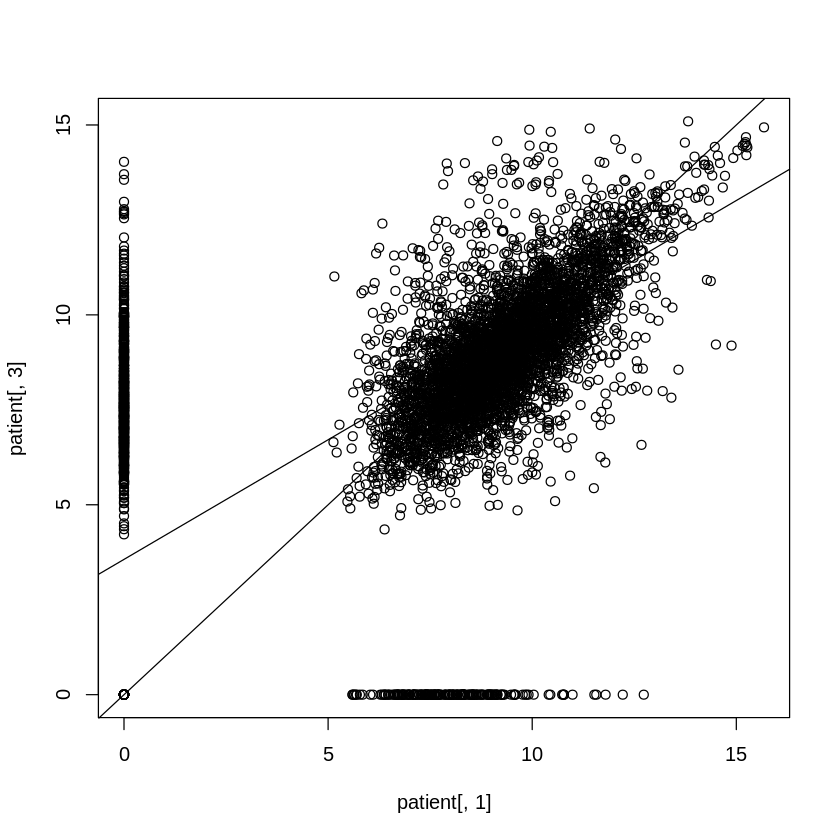

In [66]:
plot(patient[,1], patient[,3])
abline(beta[1], beta[2])
abline(0, 1)

## Non-log

In [191]:
pids <- unique(substring(sid_alltrain_local, 1, 4))

In [ ]:
# Plot scaled_strict
pid <- 'P029'
batch_no <- annot[paste0(pid, '_D0'), 'batch_info']
print(as.character(batch_no))

N <- scaled_strict[, 'N01']
D0 <- scaled_strict[, paste0(pid, '_D0')]
D8 <- scaled_strict[, paste0(pid, '_D8')]
Y <- D8 - D0
X <- N - D0

model <- lm(Y ~ X + 0)

par(mfrow = c(1,2))
plot(X, Y, asp = 1, main = model$coefficients)
abline(0, 1)
abline(0, model$coefficients, col = 'red')
abline(0, mean(Y/X, trim = 0.1), col = 'blue')
plot(Y/X)
print(mean(Y/X, trim = 0.1))

#### Investigate: Regression plots

[1] "Trimmed mean:0.0690856681270942"


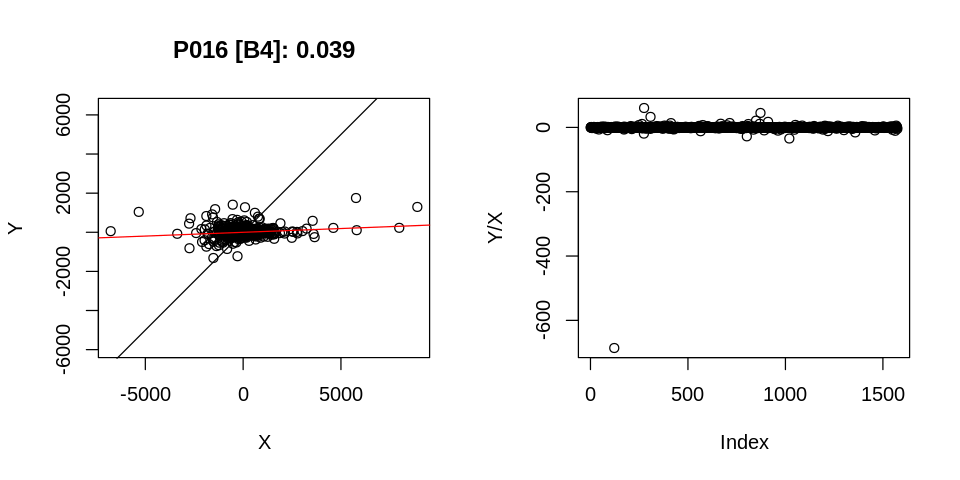

[1] "Trimmed mean:0.369057954856699"


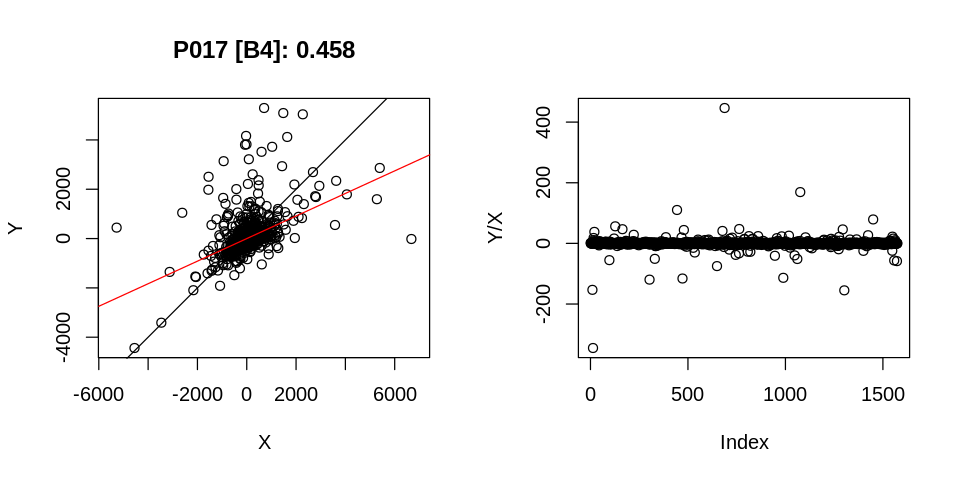

[1] "Trimmed mean:0.0365481009011711"


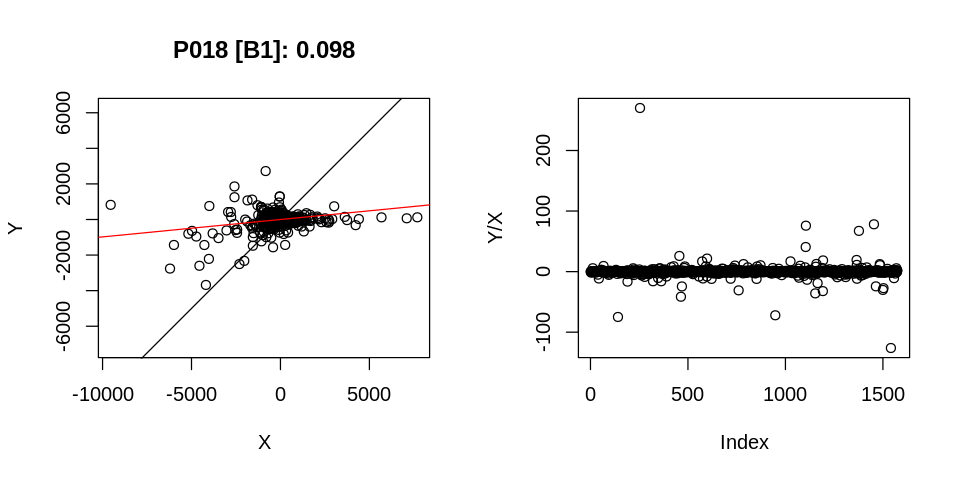

[1] "Trimmed mean:0.0857965584698896"


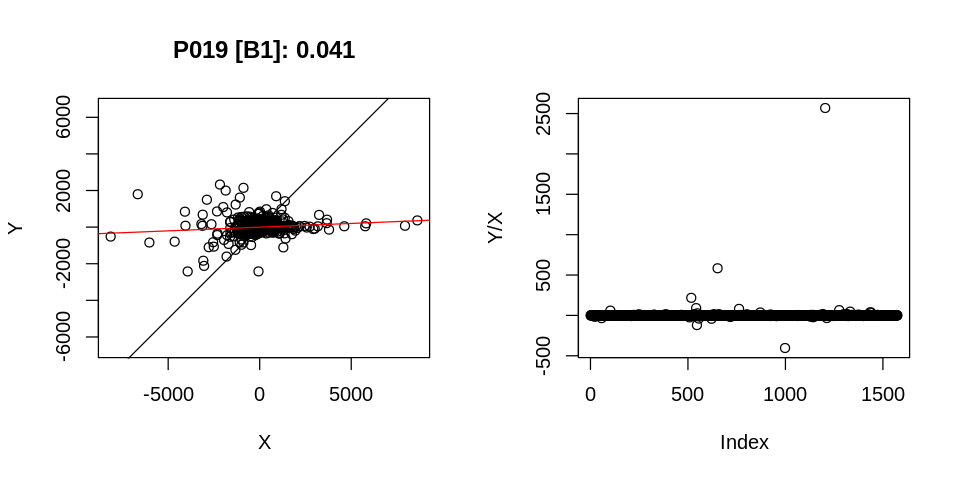

[1] "Trimmed mean:0.260579062062963"


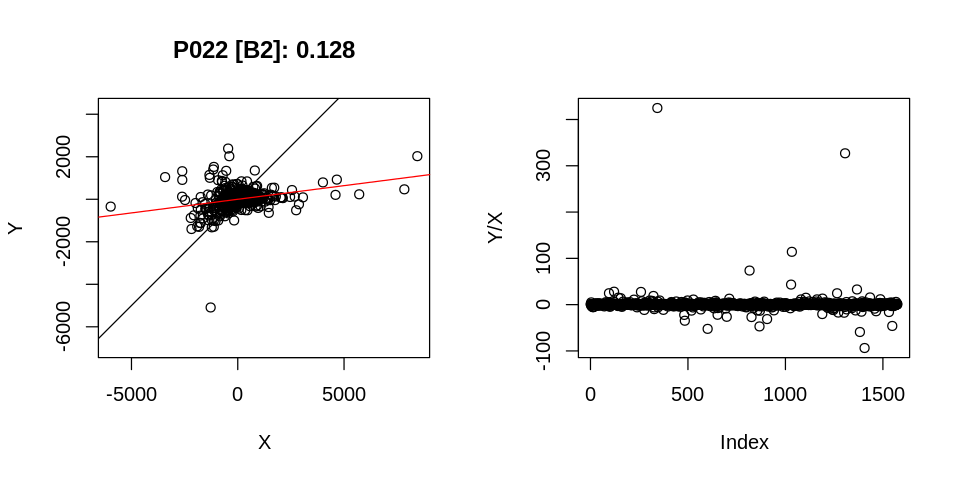

[1] "Trimmed mean:0.0254717145702784"


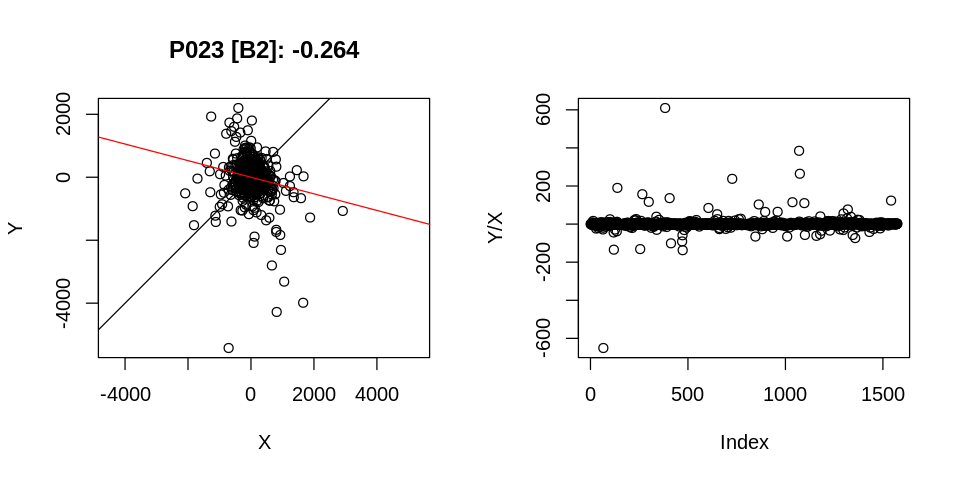

In [806]:
# CURRENT: Examining linear regression plots

Z <- scaled_strict

purity1 <- numeric(length = 0)
idx_normal <- startsWith(colnames(Z), "N")

par(mfrow = c(1, 2))
for (pid in pids[11:16]) {
  idx <- startsWith(colnames(Z), pid) | idx_normal
  patient <- Z[, idx]
  
  colnames(patient)[1:2] <- c("D0", "D8")
  X <- patient$N01 - patient$D0
  Y <- patient$D8 - patient$D0
#   Y2 <- patient$N02 - patient$D0

  model <- lm(Y ~ X + 0)
  beta <- model$coefficients
  purity1 <- c(purity1, beta)
  main <- sprintf(
    '%s [B%s]: %.3f',
    pid,
    annot[paste0(pid, '_D0'), 'batch_info'],
    beta
  )
  
  # Plot
  plot(X, Y, , asp = 1, main = main)
  abline(0, 1)
  abline(a = 0, b = beta, col = 'red')
#   abline(0, mean(Y/X, trim = 0.1), col = 'blue')
  plot(Y/X)
  print(paste0('Trimmed mean:', mean(Y/X, trim = 0.1)))
}
# names(purity1) <- pids
# print(head(purity1))

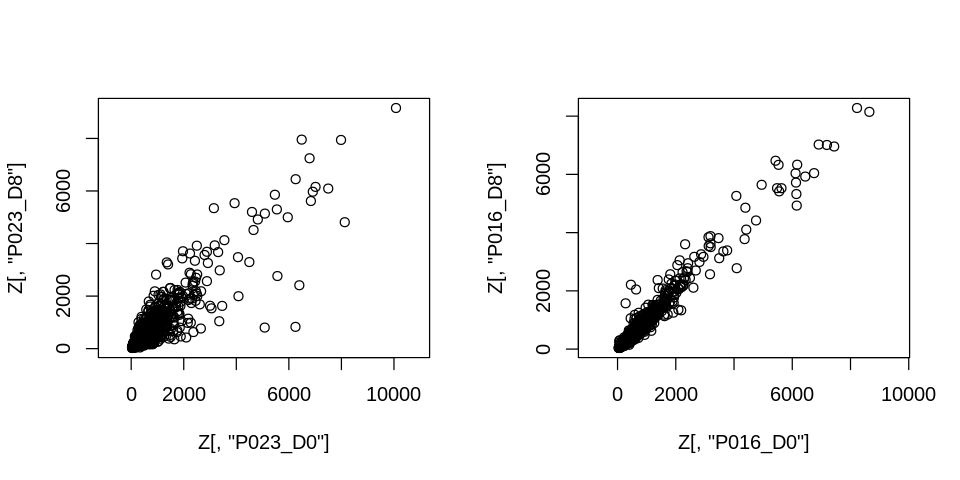

In [716]:
par(mfrow = c(1, 2))
plot(Z[, 'P023_D0'], Z[, 'P023_D8'], asp = 1)
plot(Z[, 'P016_D0'], Z[, 'P016_D8'], asp = 1)

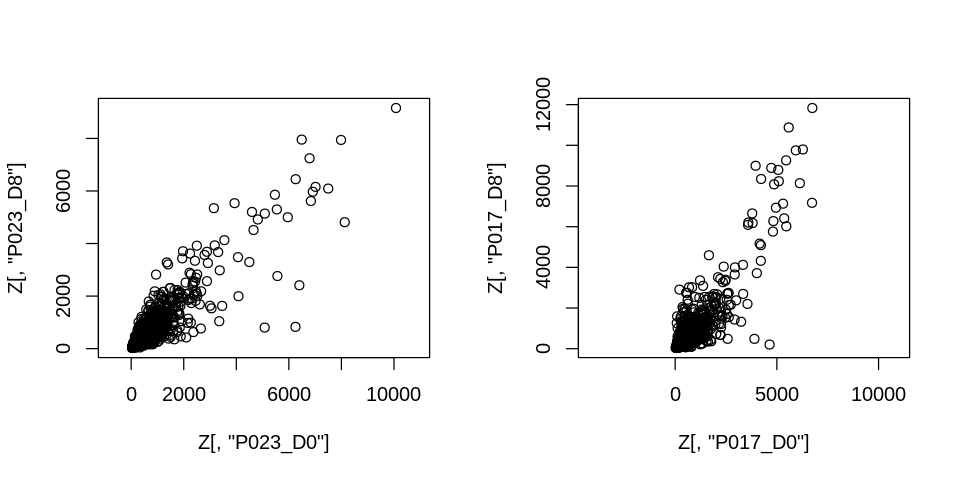

In [807]:
par(mfrow = c(1,2))
plot(Z[, 'P023_D0'], Z[, 'P023_D8'], asp = 1)
plot(Z[, 'P017_D0'], Z[, 'P017_D8'], asp = 1)

In [747]:
sids

[1] "P016_D0" "P017_D0" "P018_D0" "P019_D0" "P022_D0" "P023_D0" "P016_D8"
 [8] "P017_D8" "P018_D8" "P019_D8" "P022_D8" "P023_D8"

#### Investigate: PCA
- P023 does not have the greatest variance, even though it's regression plot is bad

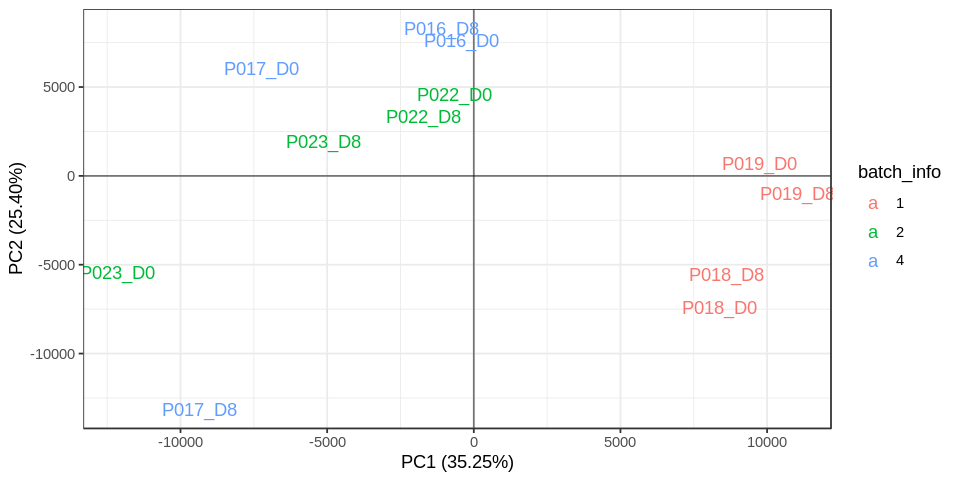

In [800]:
# What is causing the variance?
# Why are some samples so hard to regress?
# What is wrong with P023? It mainly does not match with itself. Also does not match well with others.
# Rank perturbation is stronger?

d0_sid <- paste0(pids[11:16], '_D0')
d8_sid <- paste0(pids[11:16], '_D8')
sids <- c(d0_sid, d8_sid)

plot_pca(
  Z[, sids], annot,
  label = T,
  col = 'batch_info',
  pch = 'class_info'
)

#### Investigate: CDF

In [840]:
normaliseMeanScaling <- function(
  X, target_mean = 500, trim = 0.02, ret.factor = F
) {
  trimmed_mean <- apply(X, 2, mean, trim = trim)
  scaling_factor <- target_mean / trimmed_mean
  names(scaling_factor) <- colnames(X)
  
  scaled <- sweep(X, 2, scaling_factor, `*`)
  rownames(scaled) <- rownames(X)
  
  if (ret.factor)
    return(scaling_factor)

  scaled
}

Using batch_info, class_info, subtype, label, sid as id variables
Using batch_info, class_info, subtype, label, sid as id variables


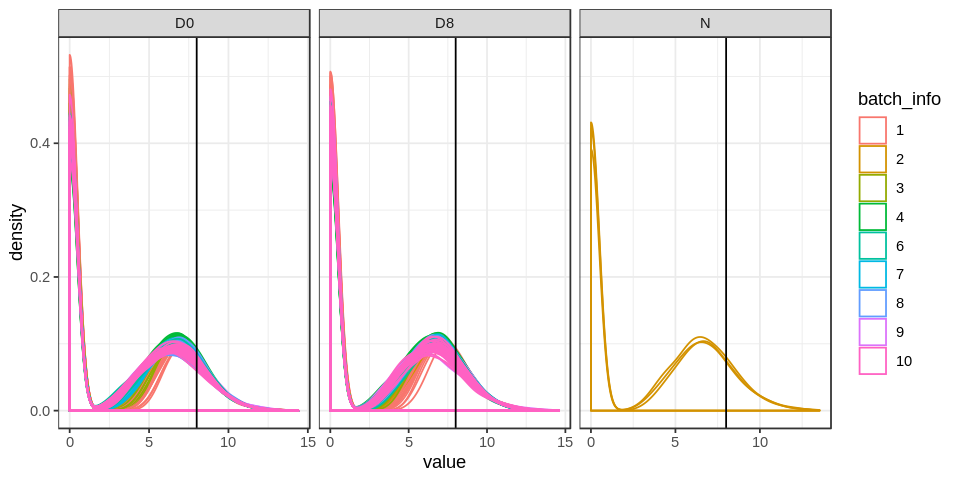

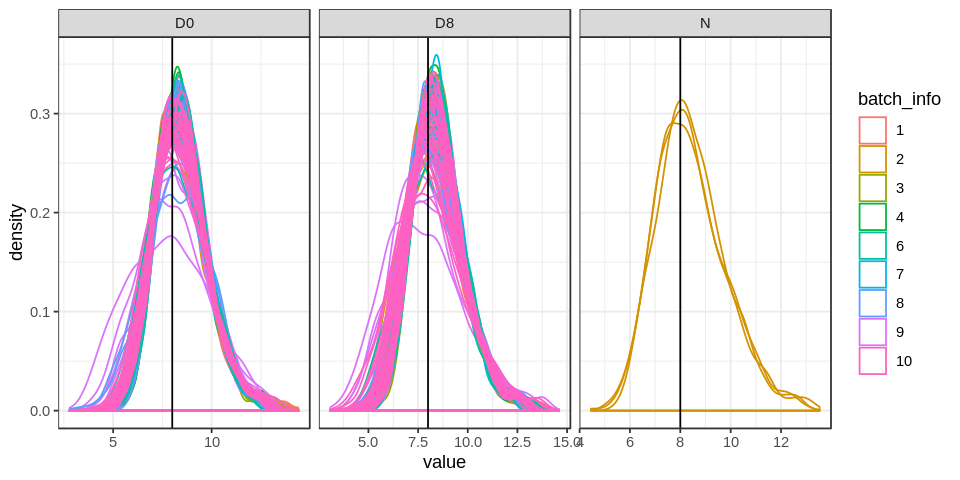

In [846]:
# log_z <- log2_transform(Z[, sids])
# plot_density(log_z, annot)

# TMS variant: Use scaling factor on probesets removed due to zeros
strict_yeoh_inverse <- unambi_yeoh[!(rowSums(unambi_yeoh == 0) == 0), ]
scaling_factor <- normaliseMeanScaling(strict_yeoh, ret.factor = T)
scaled_strict_inverse <- sweep(strict_yeoh_inverse, 2, scaling_factor, `*`)
strictest_yeoh <- rbind(scaled_strict, scaled_strict_inverse)
plot_density(log2_transform(strictest_yeoh), annot)
plot_density(log2_transform(scaled_strict), annot)

# scale removed genes before concat

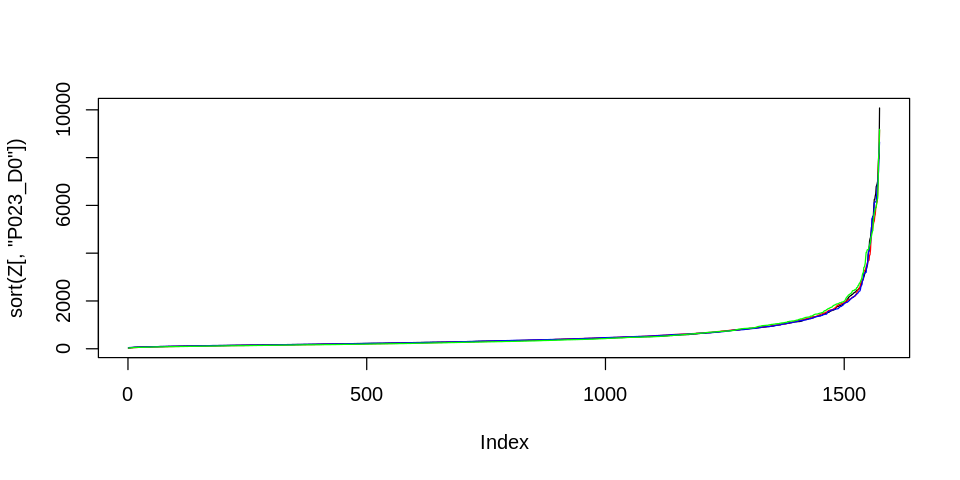

In [720]:
plot(sort(Z[, 'P023_D0']), type = 'l')
lines(sort(Z[, 'P023_D8']), col = 'red')
lines(sort(Z[, 'P016_D0']), col = 'blue')
lines(sort(Z[, 'P016_D8']), col = 'green')

,beta,label,subtype
,<dbl>,<int>,<fct>
P001,0.6531404,0,T-ALL
P004,0.3600744,0,T-ALL
P005,0.9844392,0,T-ALL
P007,0.2295698,1,T-ALL
P008,0.5160422,0,T-ALL
P010,0.1828977,0,T-ALL


Warning message:
“Removed 2 rows containing missing values (geom_point).”

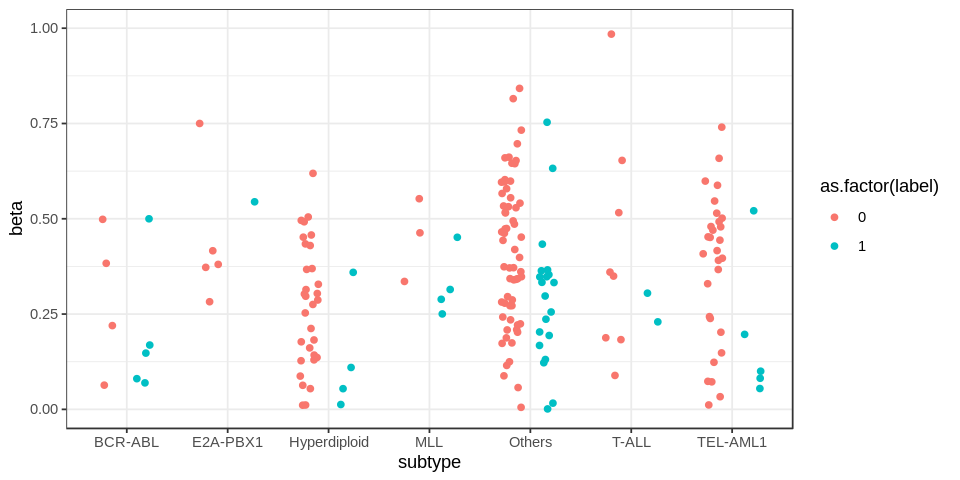

In [594]:
purity_annot <- cbind(
  beta = purity1,
  yeoh_label[names(purity1), c("label", "subtype")]
)
head(purity_annot)

ggplot(
  purity_annot,
  aes(x = subtype, y = beta, col = as.factor(label))
) +
  geom_point(position = position_jitterdodge()) +
  ylim(0, 1)

#### Single loop

In [970]:
# scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
# selected_yeoh <- removeProbesets(scaled_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"


In [1051]:
final_yeoh <- selected_yeoh[!(rownames(selected_yeoh) %in% batch_ps), ]
finale <- final_yeoh[rowSums(final_yeoh == 0) == 0, ]

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
0.2732839 0.2657161 0.2650498 0.2826670 0.2682906 0.2964012 


,P001_D0,P004_D0,P005_D0,P007_D0,P008_D0,P009_D0,P010_D0,P011_D0,P012_D0,P013_D0,⋯,P214_D8,P215_D8,P216_D8,P217_D8,P218_D8,P219_D8,P220_D8,N01,N02,N04
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200010_at,8502.6705,5896.3814,4324.6365,4666.6717,6856.5520,6998.1904,7842.3997,8980.0882,6538.1060,6554.8021,⋯,5585.2776,5395.5078,7197.0182,7291.92864,6919.0569,6629.2022,6394.2505,4834.6854,5762.1891,6431.6205
200020_at,536.1499,531.3814,761.4945,780.2775,885.4932,973.2482,1870.9116,1152.4713,608.3826,421.0704,⋯,697.7825,694.5777,984.9666,297.94275,483.8141,654.8202,647.9093,503.8237,506.3814,524.4471
200027_at,796.2204,917.9326,1155.1098,1092.4959,1209.4651,1084.1881,749.1922,1262.3268,1074.1635,730.0712,⋯,830.9174,1158.2497,684.6002,502.20934,751.5006,1017.7200,1256.6693,955.9685,924.0306,1278.0418
200050_at,583.4864,419.1628,542.6578,509.3024,763.2853,475.7504,415.7335,424.3572,939.0732,513.2571,⋯,358.5181,40.1206,312.6775,74.19959,332.5597,107.6119,474.1355,287.9319,234.5862,321.4051
200083_at,717.9095,579.2629,638.5736,658.0108,781.7541,388.8007,414.8171,706.4482,672.7247,820.3806,⋯,960.6791,880.7444,741.6978,704.08609,623.0169,778.3569,746.4403,299.8159,541.1931,438.0402
200084_at,891.6598,1117.1733,1041.0853,1005.5825,1053.6694,1425.2791,774.2288,1081.5237,1382.7290,961.3799,⋯,959.2566,989.3923,917.0719,867.33078,1007.1414,1283.6292,832.1547,994.2931,916.0149,905.7150


,D0,D8,N01,N02,N04
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200010_at,7842.3997,9043.6152,4834.6854,5762.1891,6431.6205
200020_at,1870.9116,861.8160,503.8237,506.3814,524.4471
200027_at,749.1922,595.0547,955.9685,924.0306,1278.0418
200050_at,415.7335,413.9513,287.9319,234.5862,321.4051
200083_at,414.8171,469.0977,299.8159,541.1931,438.0402
200084_at,774.2288,867.7451,994.2931,916.0149,905.7150


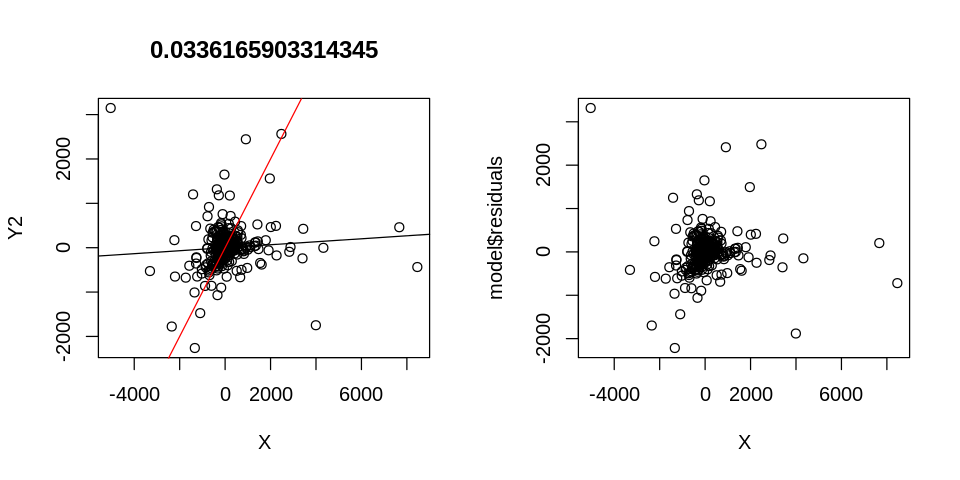

In [1093]:
## Single loop
pid <- pids[6]
unambi_yeoh

head(X)
idx_normal <- startsWith(colnames(X), "N")
idx <- startsWith(colnames(X), pid) | idx_normal
patient <- X[, idx]

# # L1 normalisation
# patient_l1 <- colSums(patient)
# print(dim(patient))
# print(patient_l1)

# patient_normalised <- sweep(patient, 2, patient_l1, '/') * 1e6
# patient <- patient_normalised

# # Filter out outliers
# # Robust regression
colnames(patient)[1:2] <- c("D0", "D8")
head(patient)
X <- patient$N04 - patient$D0
# Y <- patient$D8 - patient$D0
Y2 <- patient$D8 - patient$D0

model <- lm(Y2 ~ X + 0)
beta <- model$coefficients

# Calculate residuals if beta = 1
hypo_residuals <- Y - X

# Plot
# pdf('~/Dropbox/temp/regression.pdf')
par(mfrow = c(1, 2))
plot(X, Y2, main = beta)
abline(a = 0, b = beta)
abline(a = 0, b = 1, col = 'red')
plot(X, model$residuals)
# dev.off()

#### Hypothetical residuals

In [ ]:
# # Calculate residuals if beta = 1
# hypo_residuals <- Y2 - X

# # Plot
# par(mfrow = c(1, 2))
# plot(X, Y2, main = beta)
# abline(a = 0, b = beta)
# abline(a = 0, b = 1, col = 'red')
# plot(X, model$residuals)

### Batch effects
- Quantile normalisation does not work beacuse ranks are perturbed in a consistent manner
- I.e. A set of genes are selected to apply B.E. will experience change in rank
- Assuming that the selection of B.E. genes in each batch is random across batches
- It is hard to identify B.E. genes as each batch has a mostly unique set of B.E. genes
- It would mean almost all genes have B.E.

#### Ideas
- Filter out outliers
- Robust regression
- L1 normalisation

### Plot: Sums

In [796]:
#' @param X dataframe with features as rows and samples as columns
#' @param annot dataframe of annotation with samples as rows
#' @param ... optional arguments are passed to aes_string in ggplot
plot_pca <- function(X, annot, cex = 2, alpha = 1, label = F, ...) {  
  # PCA
  pca_obj <- prcomp(t(X))
  Z <- data.frame(pca_obj$x[, 1:4])
  eigenvalues <- (pca_obj$sdev)^2
  var_pc <- eigenvalues[1:4]/sum(eigenvalues)
  pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  # concat with annotations
  annot_cols <- unlist(list(...))
  annot1 <- annot[rownames(Z), annot_cols, drop = F]
  Z_annot <- cbind(Z, annot1)
 
  base <- ggplot(Z_annot, aes_string(
    x = "PC1",
    y = "PC2",
    label = 'rownames(Z_annot)',
    ...
  )) +
    labs(x = pc_labels[1], y = pc_labels[2]) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  
  
  if (label)
    return(base + geom_text())
  
  base +
    geom_point(cex = cex, alpha = alpha)
}

In [12]:
#' Environment: Y
plot_sum <- function(X, ylim = NULL) {
  sum_expr <- colSums(X)
  annot_sum <- data.frame(
    sid = names(sum_expr),
    sum_expr,
    annot[names(sum_expr), ]
  )
  ax <- ggplot(annot_sum, aes(label, sum_expr, col = batch_info)) +
    facet_wrap(~class_info, scales = "free_x", nrow = 1) +
    geom_point(position = position_jitterdodge())
  
  if (is.null(ylim)) {
    return(ax)
  }
  
  ax + ylim(0, ylim)
}

In [13]:
# batch_ps is performed over all probesets without filtering
length(batch_ps)

[1] 3270

In [748]:
unambi_yeoh <- removeProbesets(raw_yeoh)
strict_yeoh <- unambi_yeoh[rowSums(unambi_yeoh == 0) == 0, ]
# stricter_yeoh <- strict_yeoh[!(rownames(strict_yeoh) %in% batch_ps), ]
scaled_strict <- normaliseMeanScaling(strict_yeoh)

[1] "No. of ambiguous and AFFY probesets removed: 10503"
  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
1.4117096 1.0209830 0.9628187 1.5788775 1.1942965 3.2931112 


In [ ]:
# SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
# raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# # SCALE->REMOVE->FILTER->LOG
# scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
# selected_yeoh <- removeProbesets(scaled_yeoh)
# selected_yeoh_1 <- filterProbesets(selected_yeoh, 0.7, metadata_df)
# data <- log2_transform(selected_yeoh_1)
# yeoh_allps <- log2_transform(scaled_yeoh)
# yeoh_unfltr <- log2_transform(selected_yeoh)

In [996]:
# Compare to a set of randomly selected genes
n <- nrow(unambi_yeoh)
m <- nrow(strict_yeoh)
idx <- sample(seq_len(n), m, replace = F)
null_yeoh <- unambi_yeoh[idx, ]
nrow(null_yeoh)
nrow(strict_yeoh)

[1] 1574

[1] 1574

#### Plots

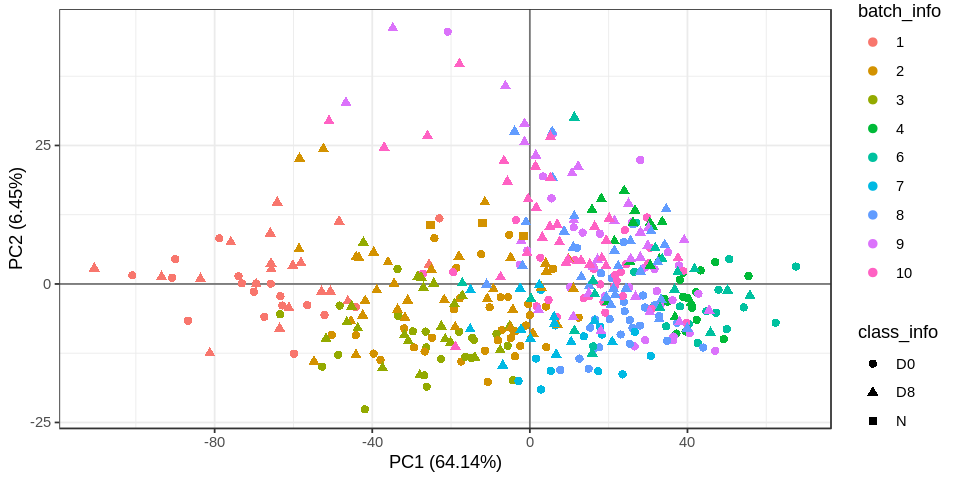

In [798]:
ax <- plot_pca(
  log2_transform(strict_yeoh), annot,
  col = "batch_info", pch = "class_info"
)
ax
# ggsave('~/Dropbox/temp/pca-strict.pdf', ax, width = 8, height = 4)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
1.4117096 1.0209830 0.9628187 1.5788775 1.1942965 3.2931112 


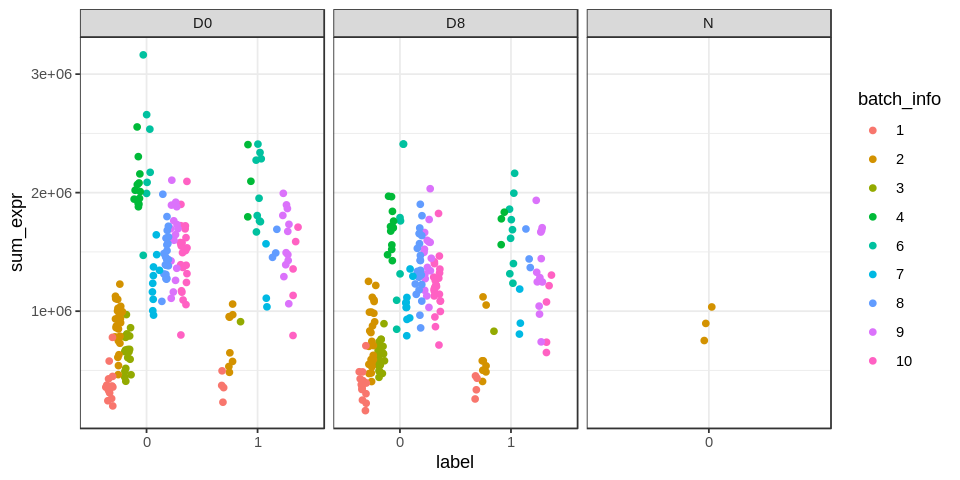

In [70]:
# check whether all genes in batch 4 are bigger than batch 1
plot_sum(strict_yeoh)

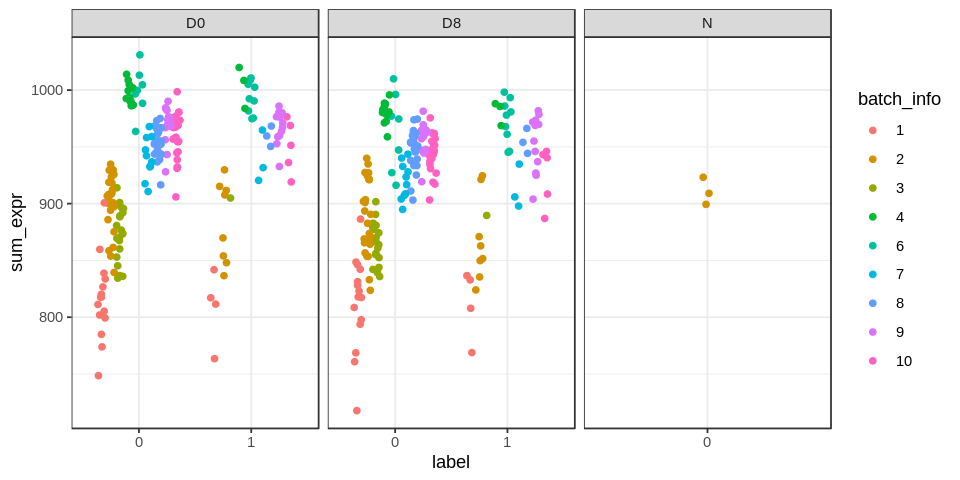

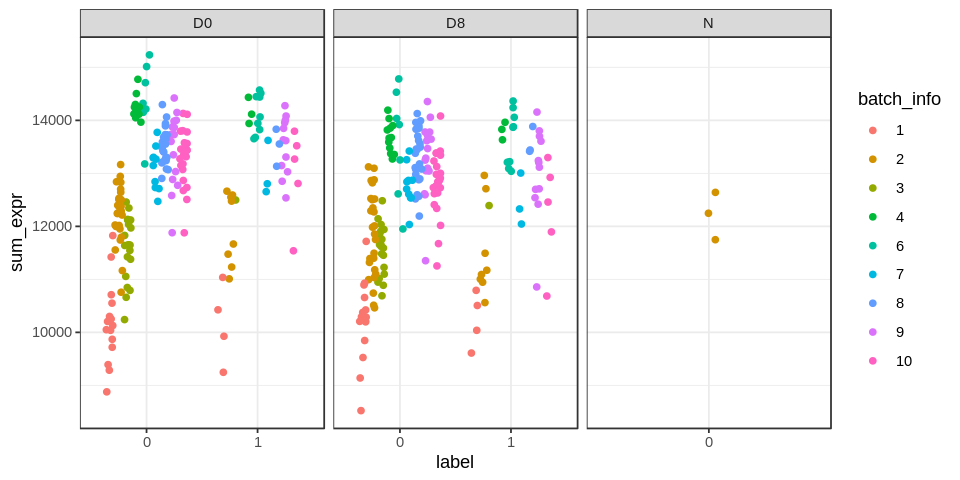

In [71]:
# High expression ps are more affected by batch effects? NO
# Affects the sum disproportionately? NO
# Comparison of the sum of 10th percentile v.s. sum of the rest
n_top <- 0.05 * nrow(strict_yeoh)
top10_percentile <- apply(log2_transform(strict_yeoh), 2, sort, decreasing = T)[1:n_top, ]
bottom90_percentile <- apply(log2_transform(strict_yeoh), 2, sort, decreasing = T)[
  (n_top + 1):nrow(strict_yeoh), ]
# middle_percentile <- apply(strict_yeoh, 2, sort, decreasing = T)[
#   n_top:(nrow(strict_yeoh) - n_top), ]
# plot_sum(top10_percentile)
# plot_sum(bottom90_percentile)

In [370]:
table(annot$subtype, annot$batch_info)

              
                1  2  3  4  5  6  7  8  9 10
  BCR-ABL       2  2  2  4  0  6  2  2  0  0
  E2A-PBX1      2  2  2  0  0  0  0  4  4  0
  Hyperdiploid  4  6  8  6  0  8  6 16 14  8
  Hypodiploid   2  0  0  0  0  0  0  0  0  0
  MLL           0  0  0  2  0  2  4  0  6  2
  Normal        0  3  0  0  0  0  0  0  0  0
  Others        8 32 14 10  0 10 10 20 20 46
  T-ALL         6  6  8  0  0  2  0  2  2  0
  TEL-AML1     14 20  8  8  0  4  4 10 10  0

In [ ]:
# Use TEL-AML1-like pids?

In [400]:
# # Linear regression to determine additive term (intercept)
# # TO-DO: How to solve the rank deltas between batch 7 and the rest?
# idx <- annot[colnames(strict_yeoh), 'label'] == 0 &
#   annot[colnames(strict_yeoh), 'subtype'] == 'TEL-AML1' &
#   annot[colnames(strict_yeoh), 'class_info'] == 'D0'
# telaml1 <- strict_yeoh[, idx]

In [407]:
# batches <- c(1:4, 6:7, 9)
# print(batches)

# # Are genes in batch 1 consistently lower than genes in batch 4? YES
# # Only batch 10 does not contain TEL-AML1 samples
# betas <- numeric()
# for (i in batches) {
#   batch_a <- telaml1[, annot[colnames(telaml1), "batch_info"] == 8]
#   batch_b <- telaml1[, annot[colnames(telaml1), "batch_info"] == i]

#   batch_a_mu <- log2_transform(rowMeans(batch_a))
#   batch_b_mu <- log2_transform(rowMeans(batch_b))

#   beta <- mean(batch_a_mu - batch_b_mu) # equivalent to least squares estimate
#   betas <- c(betas, beta)
# }
# names(betas) <- batches # term to add to batch b in order to correct
# betas

[1] 1 2 3 4 6 7 9


1          2          3          4          6          7          9 
 1.7678140  0.7083265  1.1768829 -0.5309225 -0.2922015  0.1293575 -0.3443796

In [408]:
# # Apply BE correction by multiplying by 2^beta
# epsilon <- 2 ^ betas
# print(epsilon)
# corr_batches <- vector('list')
# for (i in batches) {
#   batch <- strict_yeoh[, annot[colnames(strict_yeoh), 'batch_info'] == i]
#   corr_batch <- batch * epsilon[as.character(i)]
#   corr_batches <- append(corr_batches, list(corr_batch))
# }

        1         2         3         4         6         7         9 
3.4053758 1.6339077 2.2608777 0.6921120 0.8166549 1.0938065 0.7876466 


In [409]:
# corrected <- do.call(cbind, corr_batches)
# idx <- rownames(annot)[rownames(annot) %in% colnames(corrected)]
# corrected <- corrected[, idx]

# # TODO: Combine with batch 8
# # Is it because there is an additive term?

[1] 1574   32

[1] 1574   26

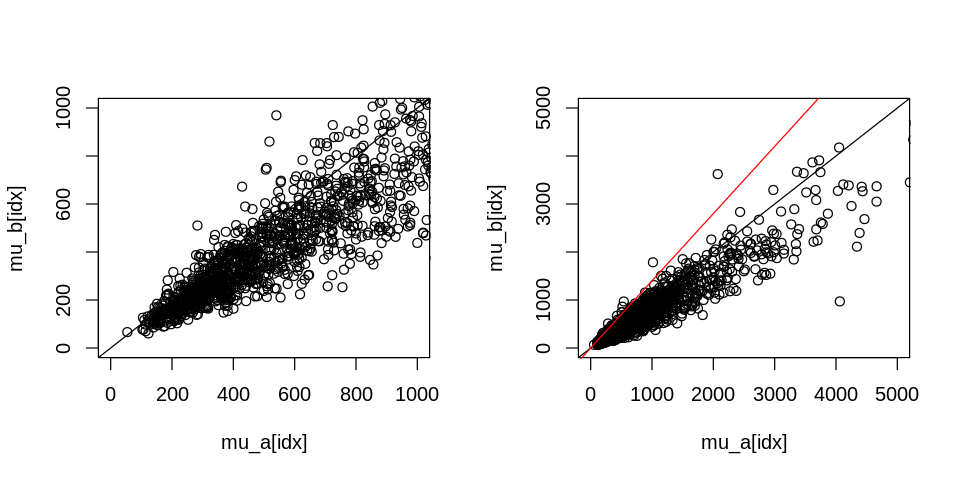

In [462]:
# # Why batch 4 still so weird - Plot linear regression - Plot non log transform
# # Explore non-log
# batch_a <- corrected[, annot[colnames(corrected), "batch_info"] == 6]
# batch_b <- corrected[, annot[colnames(corrected), "batch_info"] == 7]
# dim(batch_a)
# dim(batch_b)
# mu_a <- rowMeans(batch_a)
# mu_b <- rowMeans(batch_b)
# idx <- seq_len(nrow(batch_a))
# # idx <- sample(seq_len(nrow(batch_a)), 200, replace = F)
# par(mfrow = c(1,2))
# plot(mu_a[idx], mu_b[idx], xlim = c(0, 1000),  ylim = c(0, 1000))
# abline(0, 1)
# plot(mu_a[idx], mu_b[idx], xlim = c(0, 5000),  ylim = c(0, 5000))
# abline(0, 1)
# abline(0, 1.4, col = 'red')

[1] 1574    4

[1] 1574    3

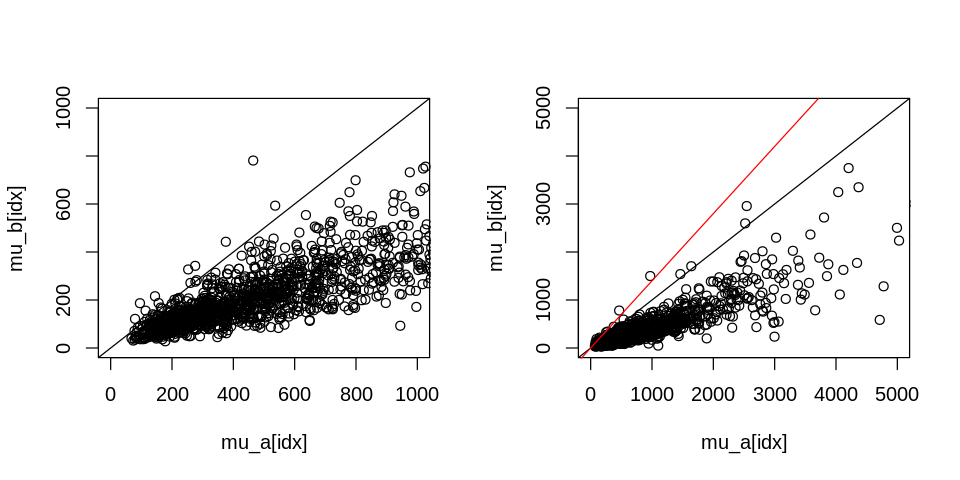

In [459]:
# # Why batch 4 still so weird - Plot linear regression - Plot non log transform
# # Explore non-log
# batch_a <- telaml1[, annot[colnames(telaml1), "batch_info"] == 8]
# batch_b <- telaml1[, annot[colnames(telaml1), "batch_info"] == 3]
# dim(batch_a)
# dim(batch_b)
# mu_a <- rowMeans(batch_a)
# mu_b <- rowMeans(batch_b)
# idx <- seq_len(nrow(batch_a))
# # idx <- sample(seq_len(nrow(batch_a)), 200, replace = F)
# par(mfrow = c(1,2))
# plot(mu_a[idx], mu_b[idx], xlim = c(0, 1000),  ylim = c(0, 1000))
# abline(0, 1)
# plot(mu_a[idx], mu_b[idx], xlim = c(0, 5000),  ylim = c(0, 5000))
# abline(0, 1)
# abline(0, 1.4, col = 'red')

In [655]:
scaled_strict <- normaliseMeanScaling(strict_yeoh)
quantile_strict <- normaliseQuantile(scaled_strict)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
1.4117096 1.0209830 0.9628187 1.5788775 1.1942965 3.2931112 


In [ ]:
pid <- 'P029'
print(annot[paste0(pid, '_D0'), 'batch_info'])

x1 <- strict_yeoh[, 'N01']
x2 <- strict_yeoh[, 'N04']
x3 <- strict_yeoh[, paste0(pid, '_D0')]
x4 <- strict_yeoh[, paste0(pid, '_D8')]
plot(sort(x1), type = 'l', xlim = c(1400, 1600))
lines(sort(x2), col = 'red')

lines(sort(x3), col = 'blue')
lines(sort(x4), col = 'green')

[1] "3"
[1] 0.1254212


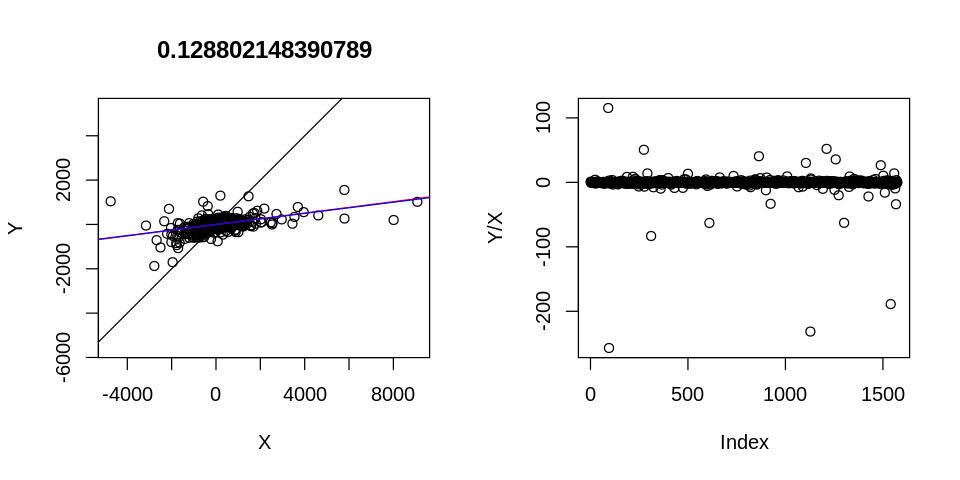

In [697]:
# Plot scaled_strict
pid <- 'P029'
batch_no <- annot[paste0(pid, '_D0'), 'batch_info']
print(as.character(batch_no))

N <- scaled_strict[, 'N01']
D0 <- scaled_strict[, paste0(pid, '_D0')]
D8 <- scaled_strict[, paste0(pid, '_D8')]
Y <- D8 - D0
X <- N - D0

model <- lm(Y ~ X + 0)

par(mfrow = c(1,2))
plot(X, Y, asp = 1, main = model$coefficients)
abline(0, 1)
abline(0, model$coefficients, col = 'red')
abline(0, mean(Y/X, trim = 0.1), col = 'blue')
plot(Y/X)
print(mean(Y/X, trim = 0.1))

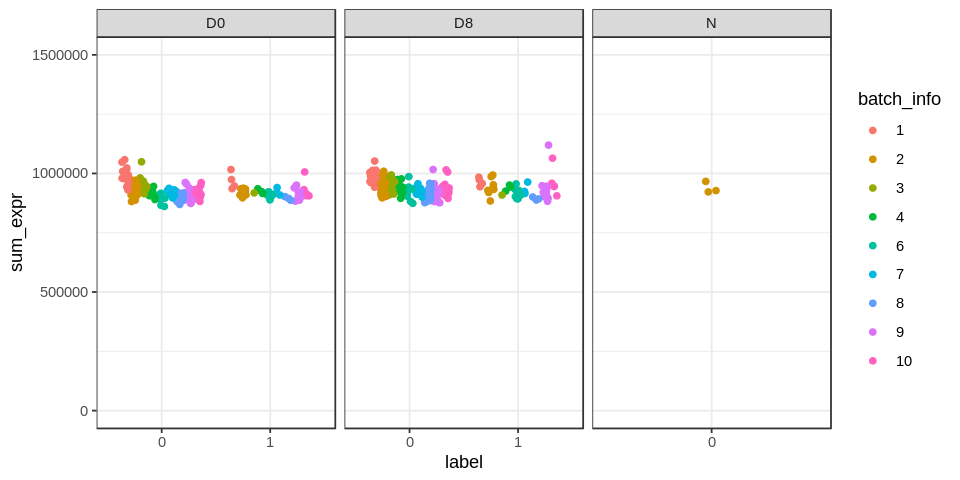

In [528]:
plot_sum(scaled_strict, 1.5e6)

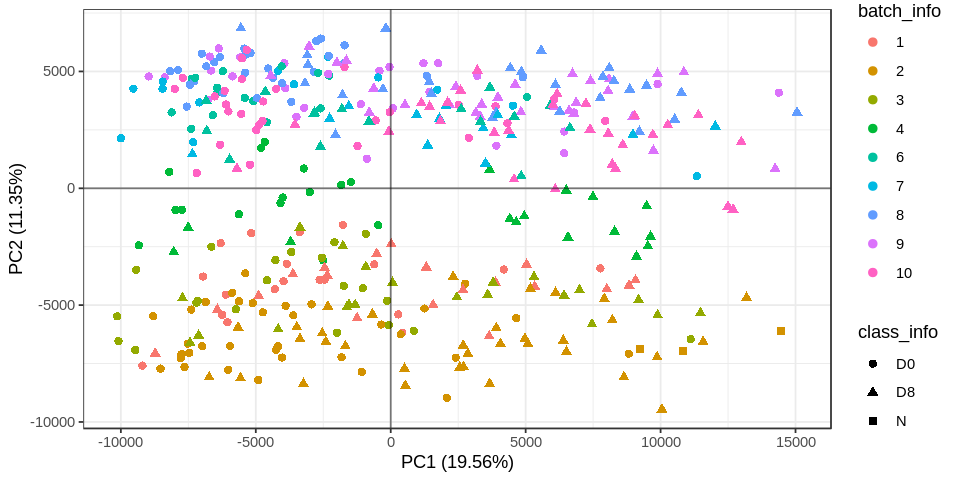

In [566]:
plot_pca(normaliseQuantile(scaled_strict), annot, col = 'batch_info', pch = 'class_info')

In [814]:
#' @param X data frame with features x samples
plot_density <- function(X, annot) {
  X_y <- cbind(
    t(X),
    annot[colnames(X), ],
    sid = colnames(X)
  )

  long_xy <- melt(X_y)

  ggplot(long_xy, aes(x = value, group = sid, color = batch_info)) +
    facet_wrap(~class_info, scales = "free_x", nrow = 1) +
    geom_density(fill = NA) +
    geom_vline(xintercept = 8)
}

Using batch_info, class_info, subtype, label, sid as id variables


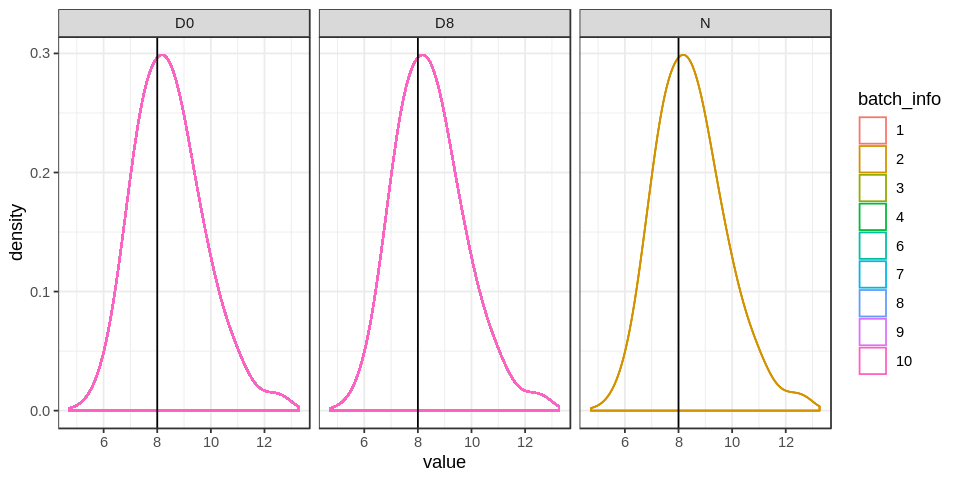

In [813]:
# Plot PDF (with B.E. probe sets)
log_patient <- log2_transform(normaliseQuantile(scaled_strict))
plot_density(log_patient, annot)

In [379]:
# batches <- c(3:4, 6:9)

# # Are genes in batch 1 consistently lower than genes in batch 4? YES
# # Only batch 10 does not contain TEL-AML1 samples
# betas1 <- numeric()
# for (idx in batches) {
#   batch_a <- strict_yeoh[, annot[colnames(strict_yeoh), "batch_info"] == 2]
#   batch_b <- strict_yeoh[, annot[colnames(strict_yeoh), "batch_info"] == idx]

#   batch_a_mu <- log2_transform(rowMeans(batch_a))
#   batch_b_mu <- log2_transform(rowMeans(batch_b))

#   beta <- mean(batch_a_mu - batch_b_mu) # equivalent to least squares estimate
#   betas1 <- c(betas1, beta)
# }
# names(betas1) <- batches # term to add to batch b in order to correct
# betas1

3          4          6          7          8          9 
 0.2775143 -1.2576382 -1.3096110 -0.5408401 -0.9177441 -0.9331155

In [366]:
print(table(batch_a_mu < batch_b_mu)) # Not log-transformed

# How jumbled up are the ranks? VERY
batch_a_rank <- apply(-batch_a, 2, rank)
batch_b_rank <- apply(-batch_b, 2, rank)


FALSE  TRUE 
   37  1537 


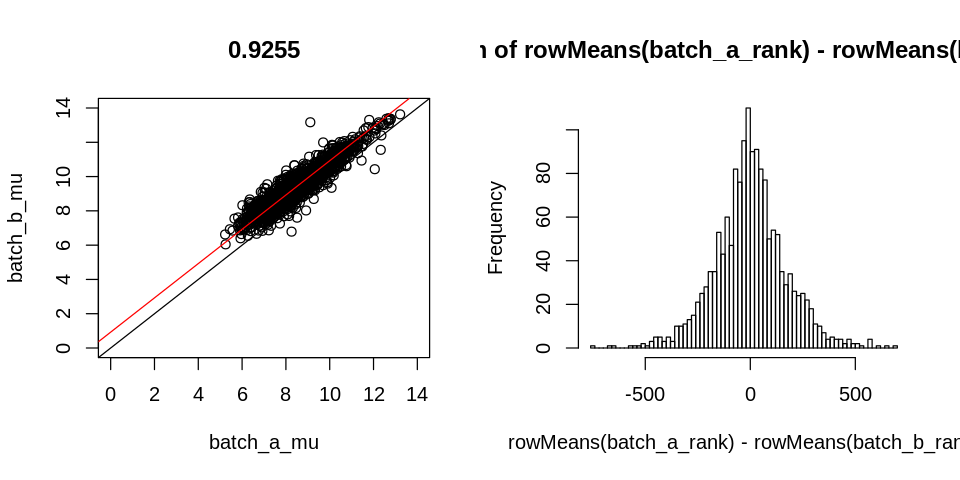

In [368]:
par(mfrow=c(1,2))
plot(
  batch_a_mu,
  batch_b_mu,
  xlim = c(0, 14),
  ylim = c(0, 14),
  main = sprintf('%.4f', beta)
)
abline(a = 0, b = 1)
abline(a = beta, b = 1, col = 'red')

hist(rowMeans(batch_a_rank) - rowMeans(batch_b_rank), 100)

In [ ]:
# After correction: Plot PCA & Plot Sums

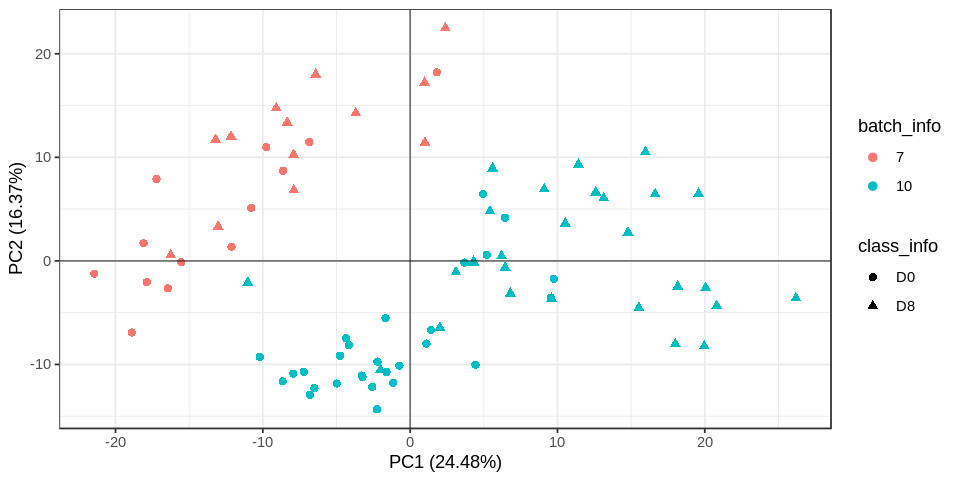

In [237]:
plot_pca(log2_transform(cbind(b1_rank, b4_rank)), annot, col = "batch_info", pch = "class_info")

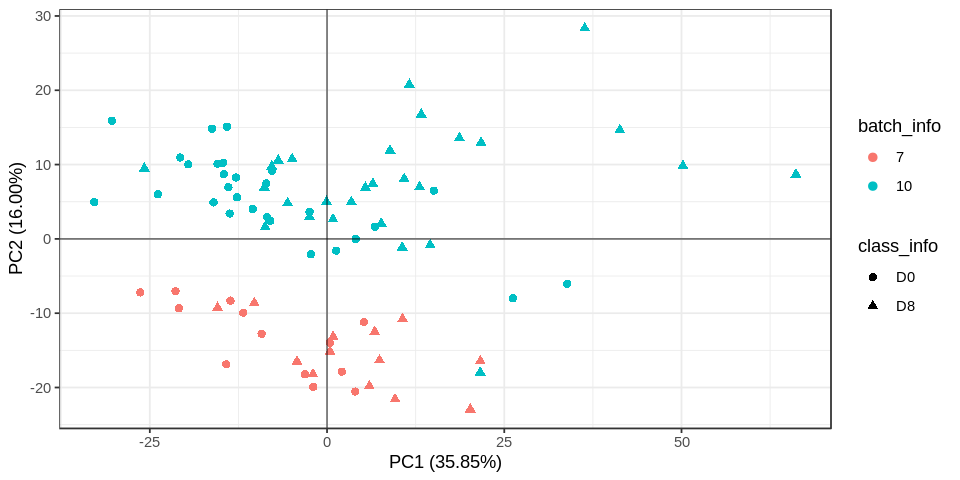

In [238]:
plot_pca(log2_transform(cbind(b1, b4)), annot, col = "batch_info", pch = "class_info")

Using batch_info, class_info, subtype, label, sid as id variables


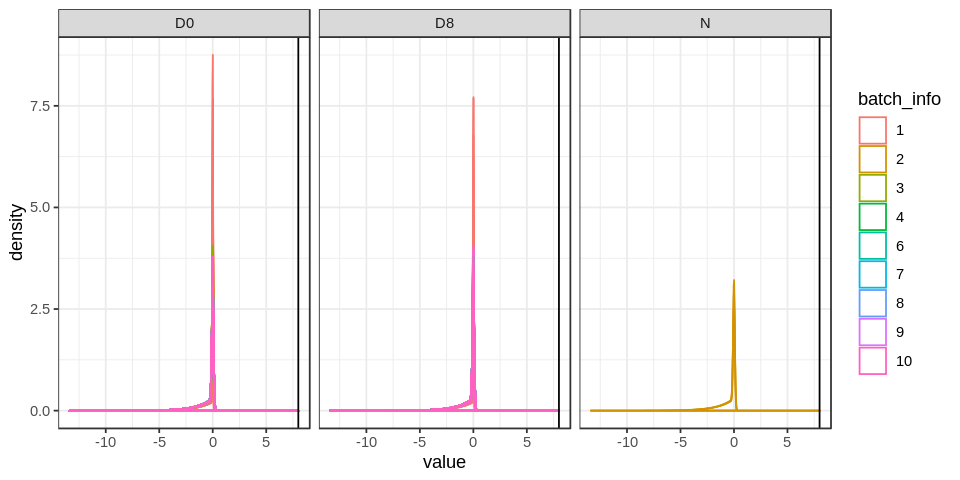

In [169]:
# Plot PDF (wo B.E. probe sets)
gfs_yeoh %>%
  log2_transform() %>%
  t() %>%
  cbind(
    annot[rownames(.), ],
    sid = rownames(.)
  ) %>%
  melt() %>%
  ggplot(aes(x = value, group = sid, color = batch_info)) +
    facet_wrap(~class_info, scales = "free_x", nrow = 1) +
    geom_density(fill = NA) +
    geom_vline(xintercept = 8)

Using batch_info, class_info, subtype, label, sid as id variables


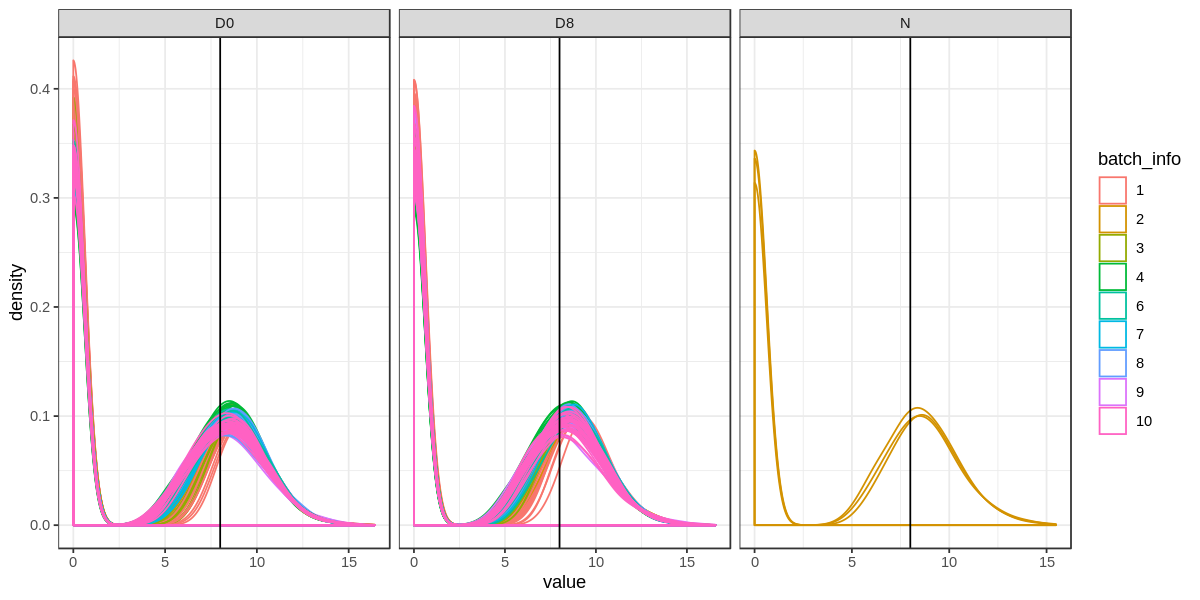

In [528]:
# Plot PDF (with B.E. probe sets)
# log_patient <- log2_transform(selected_yeoh)
log_patient <- log2_transform(selected_yeoh)
log_xy <- cbind(
  t(log_patient),
  Y[colnames(log_patient), ],
  sid = colnames(log_patient)
)

long_xy <- melt(log_xy)

ggplot(long_xy, aes(x = value, group = sid, color = batch_info)) +
  facet_wrap(~class_info, scales = "free_x", nrow = 1) +
  geom_density(fill = NA) +
  geom_vline(xintercept = 8)

#### Experiment (batch effect probesets: zero expr)

In [849]:
batch_info <- Y[colnames(unambi_yeoh), "batch_info"]
batch_idx <- setdiff(seq_len(10), 5)

batch_pct_zero <- data.frame(B1 = rep(0, nrow(unambi_yeoh)))
rownames(batch_pct_zero) <- rownames(unambi_yeoh)
for (i in batch_idx) {
  batch <- unambi_yeoh[, batch_info == i]
  n <- ncol(batch)
  
  pct_zero <- rowSums(batch == 0) / n
  name <- sprintf('B%d', i)
  batch_pct_zero[, name] <- pct_zero
}

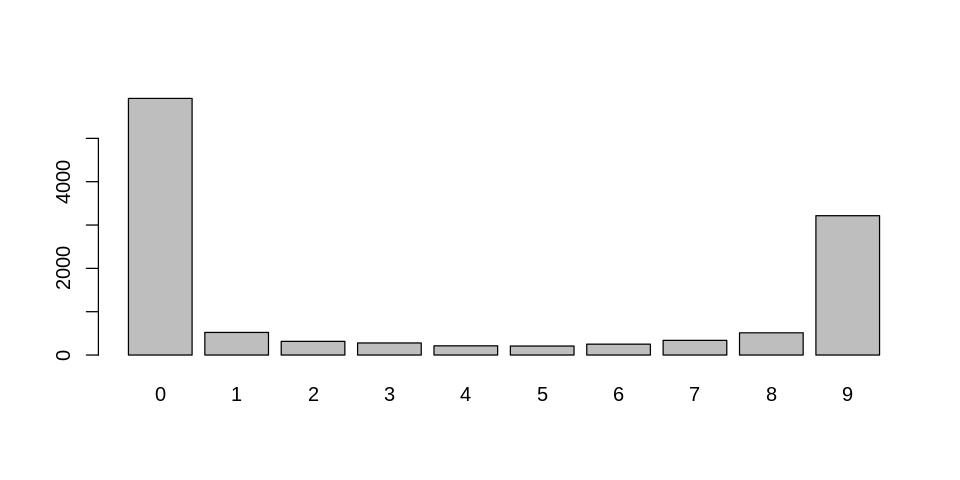

In [850]:
barplot(table(rowSums(batch_pct_zero > 0.9)))

In [843]:
mostly_zero <- rownames(batch_pct_zero)[rowSums(batch_pct_zero > 0.9) == 9]

In [853]:
fltr_pct_zero <- batch_pct_zero[!(rownames(batch_pct_zero) %in% mostly_zero), ]

In [857]:
row_var <- apply(fltr_pct_zero, 1, var)
row_range <- apply(fltr_pct_zero, 1, function(x) max(x) - min(x))

In [858]:
big_range <- rownames(fltr_pct_zero)[row_range > .4]
print(length(mostly_zero))
print(length(big_range))
print(length(batch_ps))

[1] 1802
[1] 2490
[1] 3453


In [860]:
batch_all <- Reduce(union, list(mostly_zero, big_range, batch_ps))
print(length(batch_all))
print(length(intersect(big_range, batch_ps)))

[1] 6615
[1] 1096


## Plot: Estimated purities

,purity1,label,subtype
,<dbl>,<int>,<fct>
P001,0.7702559,0,T-ALL
P004,0.6192820,0,T-ALL
P005,0.6708804,0,T-ALL
P007,0.7104539,1,T-ALL
P008,0.7707158,0,T-ALL
P010,0.8054178,0,T-ALL


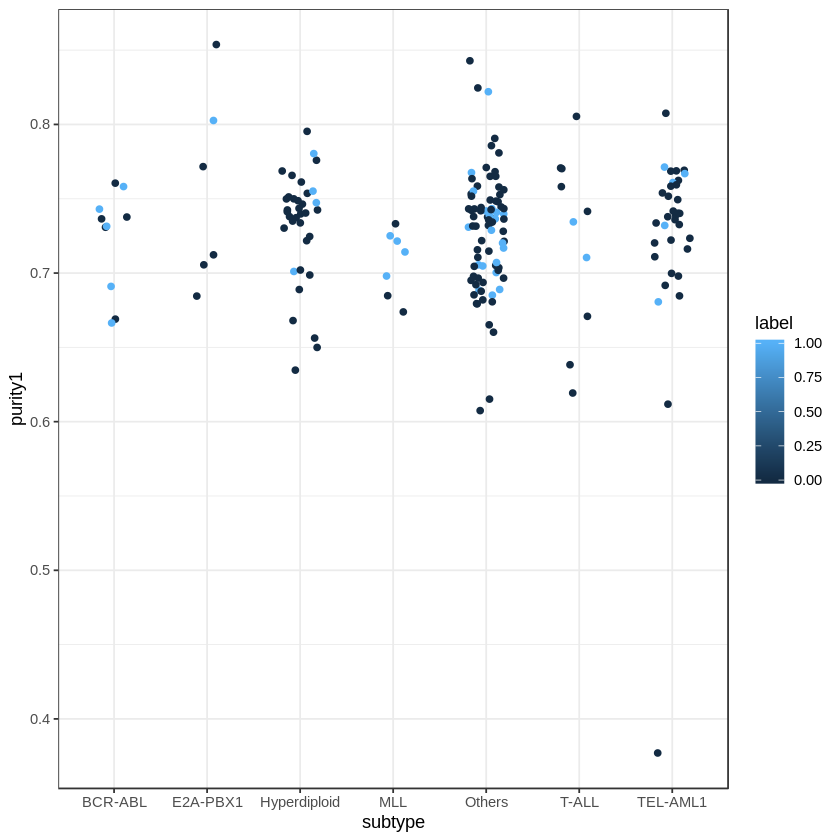

In [220]:
purity_annot <- cbind(
  purity1,
  yeoh_label[names(purity1), c("label", "subtype")]
)
head(purity_annot)

ggplot(
  purity_annot,
  aes(x = subtype, y = purity1, col = label)
) +
  geom_point(position = position_jitterdodge())

### Log-transformed

In [217]:
purity2 <- numeric(length = 0)
idx_normal <- startsWith(colnames(data), "N")
for (pid in pids) {
  idx <- startsWith(colnames(data), pid) | idx_normal
  patient <- data[, idx]
  
  colnames(patient)[1:2] <- c("D0", "D8")
  X <- patient$N01 - patient$D0
#   Y <- patient$D8 - patient$D0
  Y2 <- patient$N02 - patient$D0

  model <- lm(Y2 ~ X + 0)
  beta <- model$coefficients
  purity2 <- c(purity2, beta)
  
#   # Plot
#   with(patient, plot(N01 - D0, D8 - D0))
#   abline(a = 0, b = beta)
}
names(purity2) <- pids
print(head(purity2))

     P001      P004      P005      P007      P008      P010 
0.8163431 0.5921012 0.6419229 0.7130749 0.8358285 0.9336911 


#### Average across 3 normal patients

In [149]:
purity1 <- numeric(length = 0)
for (pid in pids) {
  idx <- startsWith(colnames(data), pid) | startsWith(colnames(data), "N")
  patient <- data[, idx]
  colnames(patient)[1:2] <- c("D0", "D8")
  model <- lm(D8 ~ N01 + D0 + 0, data = patient)
  beta <- model$coefficients
  total <- unname(beta[1] + beta[2])
  print(total)
  normal_purity <- unname(beta[1]) / total
  purity1 <- c(purity1, normal_purity)
}
names(purity1) <- pids

purity2 <- numeric(length = 0)
for (pid in pids) {
  idx <- startsWith(colnames(data), pid) | startsWith(colnames(data), "N")
  patient <- data[, idx]
  colnames(patient)[1:2] <- c("D0", "D8")
  model <- lm(D8 ~ N02 + D0 + 0, data = patient)
  beta <- model$coefficients
  total <- unname(beta[1] + beta[2])
  normal_purity <- unname(beta[1]) / total
  purity2 <- c(purity2, normal_purity)
}
names(purity2) <- pids

purity4 <- numeric(length = 0)
for (pid in pids) {
  idx <- startsWith(colnames(data), pid) | startsWith(colnames(data), "N")
  patient <- data[, idx]
  colnames(patient)[1:2] <- c("D0", "D8")
  model <- lm(D8 ~ N04 + D0 + 0, data = patient)
  beta <- model$coefficients
  total <- unname(beta[1] + beta[2])
  normal_purity <- unname(beta[1]) / total
  purity4 <- c(purity4, normal_purity)
}
names(purity4) <- pids

purity <- cbind(purity1, purity2, purity4)
head(purity)

# logi_idx <- patient == 0
# idx <- !(logi_idx[,1] | logi_idx[,3])
# patient_fltr <- patient[idx, ]

[1] 0.9882965
[1] 1.00265
[1] 0.9502678
[1] 0.9967384
[1] 0.9986117
[1] 0.9459622
[1] 0.9756547
[1] 1.011201
[1] 1.002128
[1] 1.009612
[1] 0.9969108
[1] 0.9890448
[1] 0.9864468
[1] 0.9477787
[1] 0.969434
[1] 0.9355953
[1] 0.9812114
[1] 0.9683993
[1] 0.9911178
[1] 0.9813446
[1] 1.003722
[1] 1.00565
[1] 0.9287601
[1] 0.9659403
[1] 0.9367892
[1] 0.9991669
[1] 1.001308
[1] 1.00973
[1] 0.9713389
[1] 1.002315
[1] 0.9840928
[1] 0.997922
[1] 1.002274
[1] 0.9800166
[1] 0.9634026
[1] 1.010972
[1] 0.9943984
[1] 0.9954956
[1] 0.980891
[1] 1.01208
[1] 0.9738122
[1] 0.9775419
[1] 0.9936506
[1] 0.986645
[1] 1.01224
[1] 0.9807345
[1] 0.9822325
[1] 0.974445
[1] 1.001028
[1] 1.007432
[1] 1.011999
[1] 0.9625094
[1] 0.9315819
[1] 0.983985
[1] 1.001882
[1] 0.92227
[1] 0.9346212
[1] 0.9626661
[1] 0.9612207
[1] 0.9658726
[1] 0.9471884
[1] 0.9701765
[1] 0.9552702
[1] 0.9480054
[1] 0.9312252
[1] 0.979101
[1] 0.9786837
[1] 1.000042
[1] 0.9917184
[1] 0.9594306
[1] 0.9784286
[1] 1.011224
[1] 0.9224338
[1] 1.00737

,purity1,purity2,purity4
P001,0.6809524,0.7112799,0.6187092
P004,0.4065994,0.5418857,0.3572875
P005,0.7228398,0.7266088,0.6257608
P007,0.3121366,0.3854831,0.2760492
P008,0.5980741,0.6566989,0.5601720
P010,0.3445284,0.3647865,0.3298262


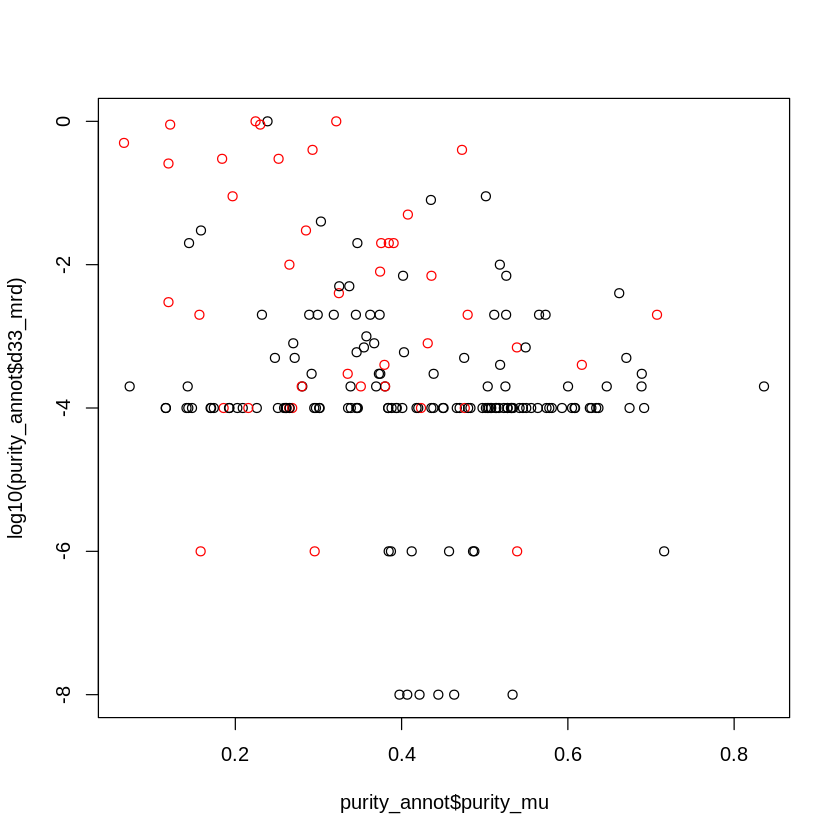

In [156]:
purity_annot <- cbind(
  purity_mu,
  yeoh_label[names(purity_mu), c("label", "subtype", "d33_mrd")]
)
plot(purity_annot$purity_mu, log10(purity_annot$d33_mrd), col = purity_annot$label + 1)

,purity1,label,subtype
,<dbl>,<int>,<fct>
P001,0.90618886,0,T-ALL
P004,0.33294076,0,T-ALL
P005,0.95161529,0,T-ALL
P007,0.36008115,1,T-ALL
P008,0.58768149,0,T-ALL
P010,0.03795859,0,T-ALL


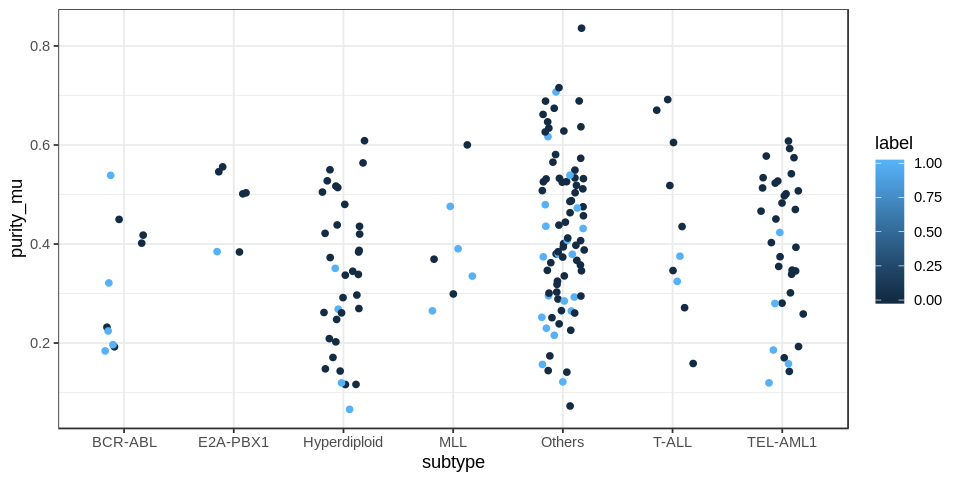

In [1119]:
purity_annot <- cbind(
  purity1,
  yeoh_label[names(purity1), c("label", "subtype")]
)
head(purity_annot)

ggplot(
  purity_annot,
  aes(x = subtype, y = purity_mu, col = label)
) +
  geom_point(position = position_jitterdodge())

In [ ]:
# Biological variance genes are excluded! :(
# TO-DO: Scaling all samples destroys signals

# TMS according to class

# TMS calculate and then reintroduce zeros and zero-linked values

In [625]:
tail(sort(x1))

[1] 11.05813 11.21654 11.29205 11.29445 11.48976 12.02472

[1] 3
Levels: 1 2 3 4 5 6 7 8 9 10


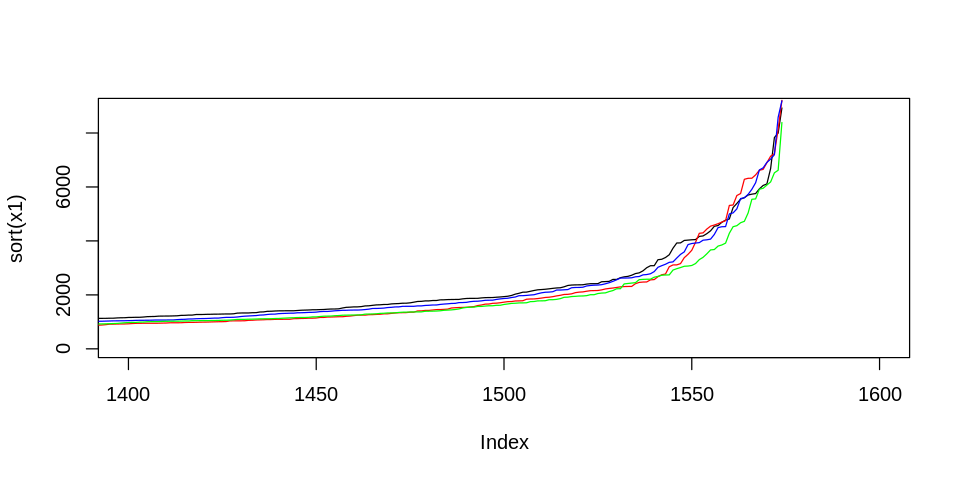

In [653]:
pid <- 'P029'
print(annot[paste0(pid, '_D0'), 'batch_info'])
x1 <- strict_yeoh[, 'N01']
x2 <- strict_yeoh[, 'N04']
x3 <- strict_yeoh[, paste0(pid, '_D0')]
x4 <- strict_yeoh[, paste0(pid, '_D8')]
plot(sort(x1), type = 'l', xlim = c(1400, 1600))
lines(sort(x2), col = 'red')

lines(sort(x3), col = 'blue')
lines(sort(x4), col = 'green')

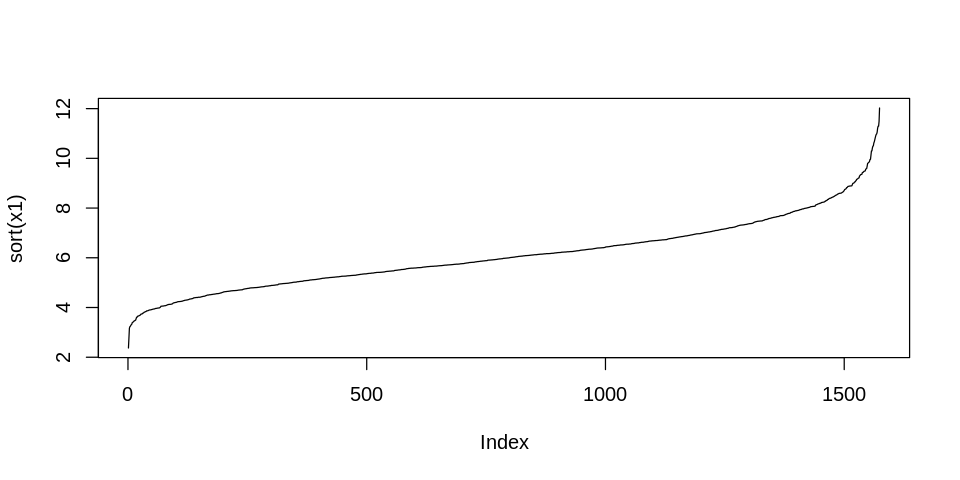

In [623]:
x1 <- log2_transform(strict_yeoh[, 'P010_D0'])
plot(sort(x1), type = 'l')